# Introdução

Este trabalho utiliza um banco de dados real e público referente ao uso do sistema público de transporte no município de Teresina. O objetivo é desenvolver um modelo para a previsão de passageiros e para os valores recebidos com as passagens.

De acordo com os problemas que surgirem, utilizaremos algumas técnicas de correção para obter uma análise mais eficiente e usaremos linguagem python e utlizaremos pacotes de acordo com a necessidade da operação

In [1]:
import pandas as pd
import numpy as np

from function_files import files #  funções criada para carregar os arquivos
from function_files import pas

# pacote gráficos
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# configuração dos gráficos 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

Construímos duas funções para iniciar o processo de trabalho de análise de dados, a primeira, *files()* tem como objetivo carregar todos os arquivos que iremos trabalhar. Possuímos a limitação que o banco de dados não é conectado a nenhum sistema, como SQL ou cloud. Para superar essa dificuldade, realizamos o download considerando um período mensal. 

Ao após a inclusão dos dados, a função construída realiza a união do arquivos num único arquivo para podermos manipular unidos.

A função *pas()* constroi outro arquivo com a quantidade de passageiros diários, que iremos utlizar para realizar a previsão de passageiros.

In [2]:
df = files(22)
freq_pas = pas(df)

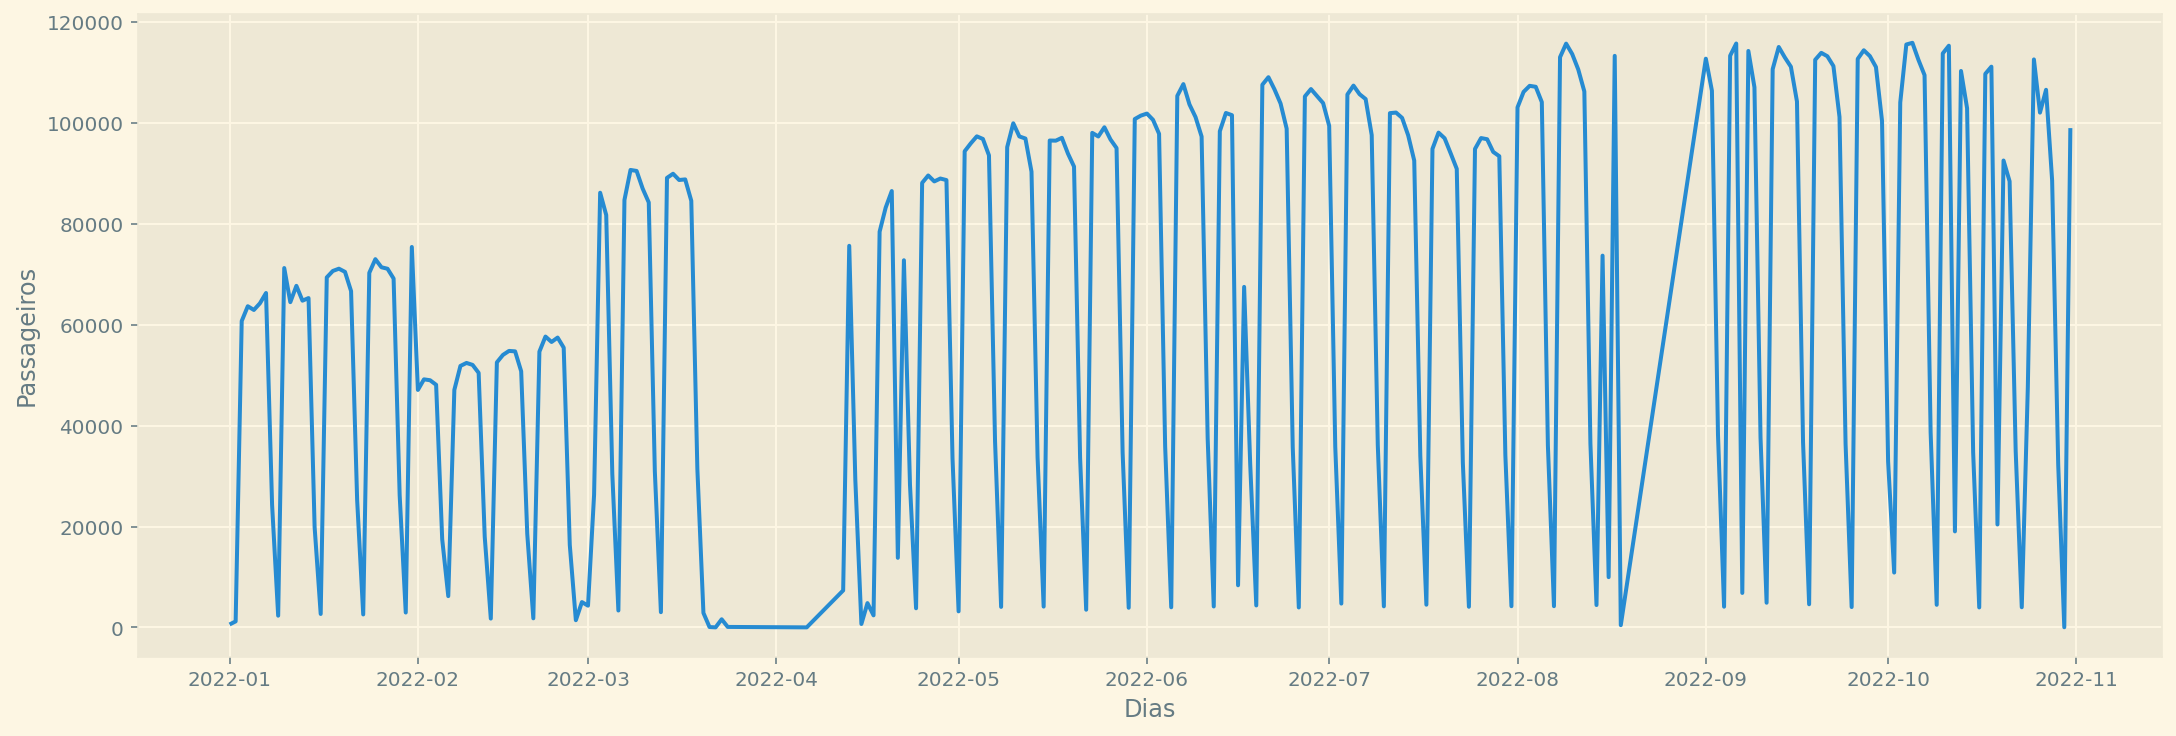

In [3]:
# gráfico com a vizualização da linha do tempo de 2022
def plot_ts():
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    sns.lineplot(x = freq_pas['Data Coleta'], y = freq_pas['Passageiros'])
    ax.set_xlabel('Dias')
    plt.show()

plot_ts()

O gráfico da série temporal indica que existe uma sanzonalidade semanal, mas evindencia problemas que teremos que tratar para fazer a predição com série temporal e rede neurais. O mais evidente é o período zerado, que corresponde ao período de greve de 23 dias dos motoristas e cobradores de ônibus. Outro fator que pode prejudicar a criação de uma predição são feriados pois ocorrem uma diminuição significativa do número de passageiros. 

link notícia greve: https://g1.globo.com/pi/piaui/noticia/2022/04/12/chega-ao-fim-greve-de-motoristas-e-cobradores-de-onibus-em-teresina-apos-23-dias.ghtml

A tabela a seguir apresenta as medidas descritivas mais importantes e o problema dos valores mínimos. 

O único dia que tem uma valor mais próximo da realidade é o domingo.

Importante destacar que o valor mínimo irá influenciar o valor da média e do desvio-padrão devido ao seu inclusão para os cálculos dessas medidas.

In [4]:
# tabela com medidas descritivas

def medidas(freq_pas):
    data_day = freq_pas.groupby('dia_semana')['Passageiros'].describe().round(2).reset_index()
    data_day = data_day.set_index('dia_semana')
    return(data_day)

data_day = medidas(freq_pas)
data_day

,count,mean,std,min,25%,50%,75%,max
dia_semana,,,,,,,,
0,40.0,83984.00,30549.58,26.0,71009.00,95048.5,105303.75,113803.0
1,39.0,84991.46,33666.52,1.0,67575.50,97335.0,108405.00,115768.0
2,40.0,79814.40,34240.50,0.0,61350.00,96884.0,104107.25,115903.0
3,40.0,81796.85,33022.00,89.0,64648.50,94128.0,105211.00,114292.0
4,38.0,84476.00,22282.10,672.0,70071.75,91140.5,99307.00,109493.0
5,39.0,30102.05,8988.70,575.0,27221.50,33653.0,35988.00,38663.0
6,39.0,3706.67,1667.67,23.0,2900.00,3984.0,4200.00,10867.0


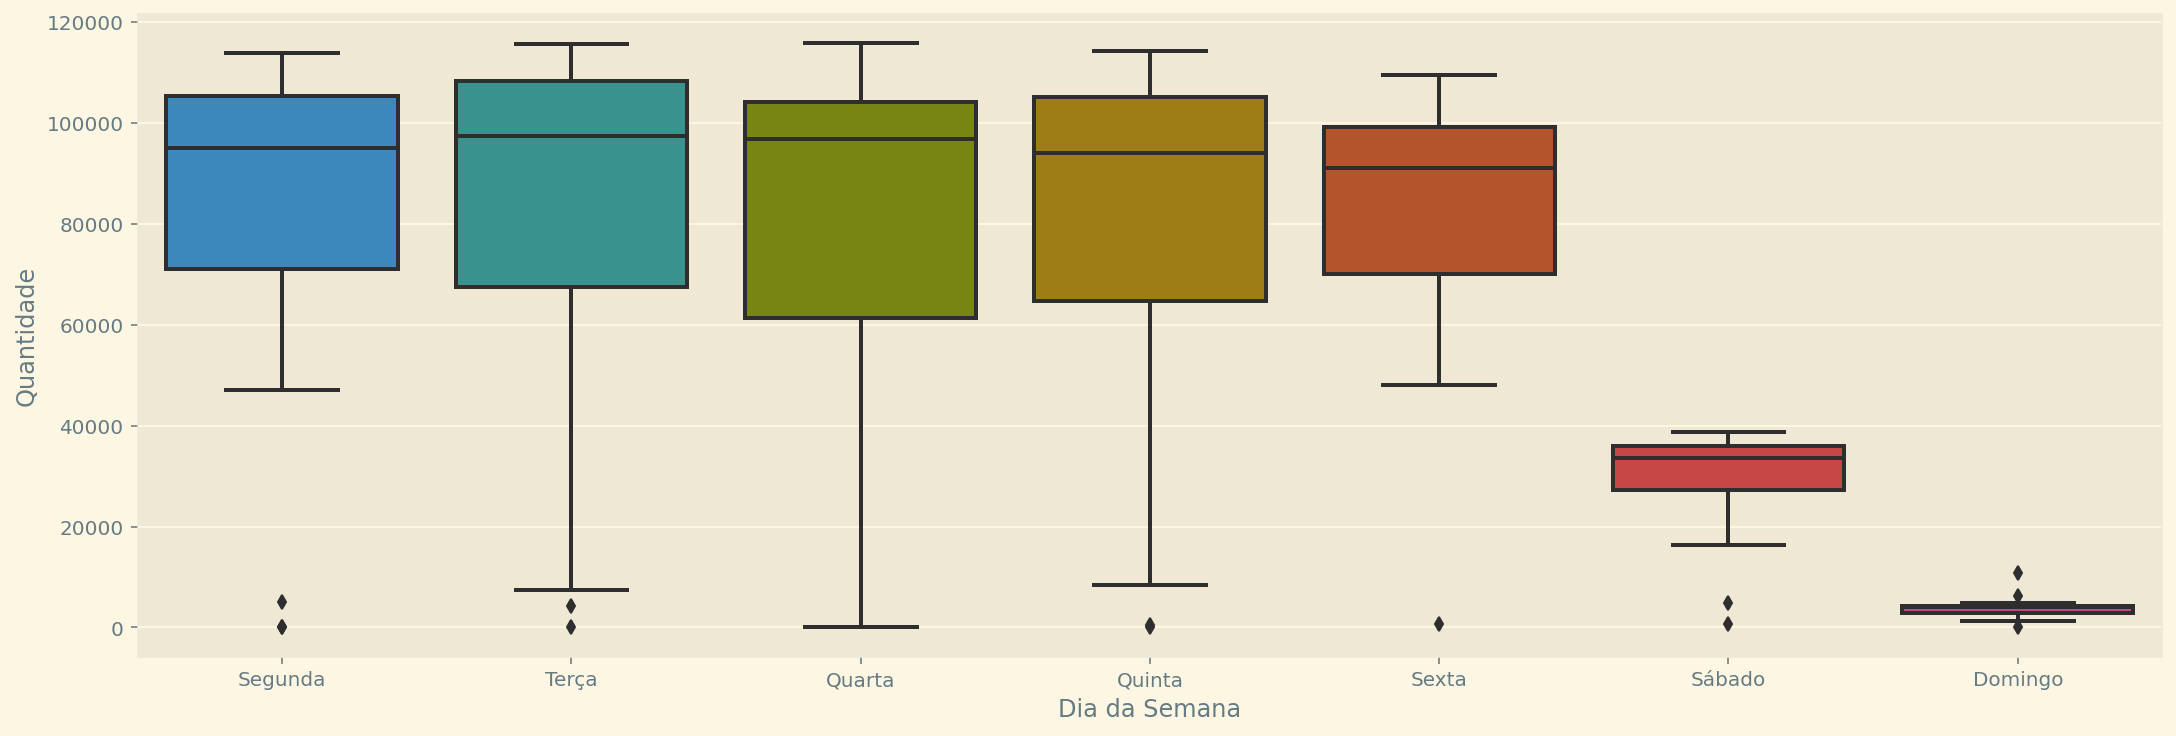

In [5]:
# box-plot com a divisão dos passageiros durante os dias da semana

def box_day(freq_pas):
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    sns.boxplot(x = freq_pas['dia_semana'], y = freq_pas['Passageiros'])
    ax.set_ylabel('Quantidade')
    ax.set_xlabel('Dia da Semana')
    ax.set_xticklabels(["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado", "Domingo"]) 
    plt.show()

box_original = box_day(freq_pas)
box_original

# Correção dos dados

Diante desses dados inexistes e irreais, teremos que definir estimadores para substituir os valores. Para isso, o primeiro procedimento foi retirar os valores muitos baixos e muito altos, os outlines existentes no gráfico. 

Para os dias úteis, limitamos esses valores a 50 mil como limite inferior e 125 mil como limite superior, para sábado, o limite inferior foi estabelecido em 18 mil e com um máximo de 40 mil. Para o domingo, foi imposto um limite mínimo de 1000 e máximo de 15 mil.

Na tabela abaixo, podemos ler medidas descritivas mais próximas realistas e o box-plot confirmando as informações de forma gráfica. 

Com essas medidas, podemos estabelecer valores para substituir os valores ausentes ou errados. 

In [6]:
# retirando data iválidas para dias úteismedidas_dia_c

freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 50000) & (freq_pas.dia_semana < 5)].index) # valores baixos
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 125000) & (freq_pas.dia_semana < 5)].index) # valores altos

# filtrando para sábado 
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 18000) & (freq_pas.dia_semana == 5)].index) # valores baixos
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 40000) & (freq_pas.dia_semana == 5)].index) # valores altos

#filtrando para domingo
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros > 15000) & (freq_pas.dia_semana == 6)].index) # valores altos
freq_pas = freq_pas.drop(freq_pas[(freq_pas.Passageiros < 1000) & (freq_pas.dia_semana == 6)].index)

data_day_c= medidas(freq_pas)
data_day_c

,count,mean,std,min,25%,50%,75%,max
dia_semana,,,,,,,,
0,35.0,93128.57,17542.89,52544.0,81602.50,98049.0,105528.00,113803.0
1,34.0,95470.79,19464.42,51836.0,89685.50,100708.5,110655.75,115768.0
2,33.0,93007.79,18655.03,52430.0,86512.00,97360.0,105721.00,115903.0
3,34.0,93262.38,18182.69,52045.0,87449.25,96885.5,107036.50,114292.0
4,36.0,87814.36,16581.05,50460.0,79509.00,91960.5,99689.00,109493.0
5,34.0,32846.41,4946.92,18552.0,31635.25,34062.5,36134.75,38663.0
6,38.0,3803.61,1574.77,1188.0,2960.00,3987.0,4201.00,10867.0


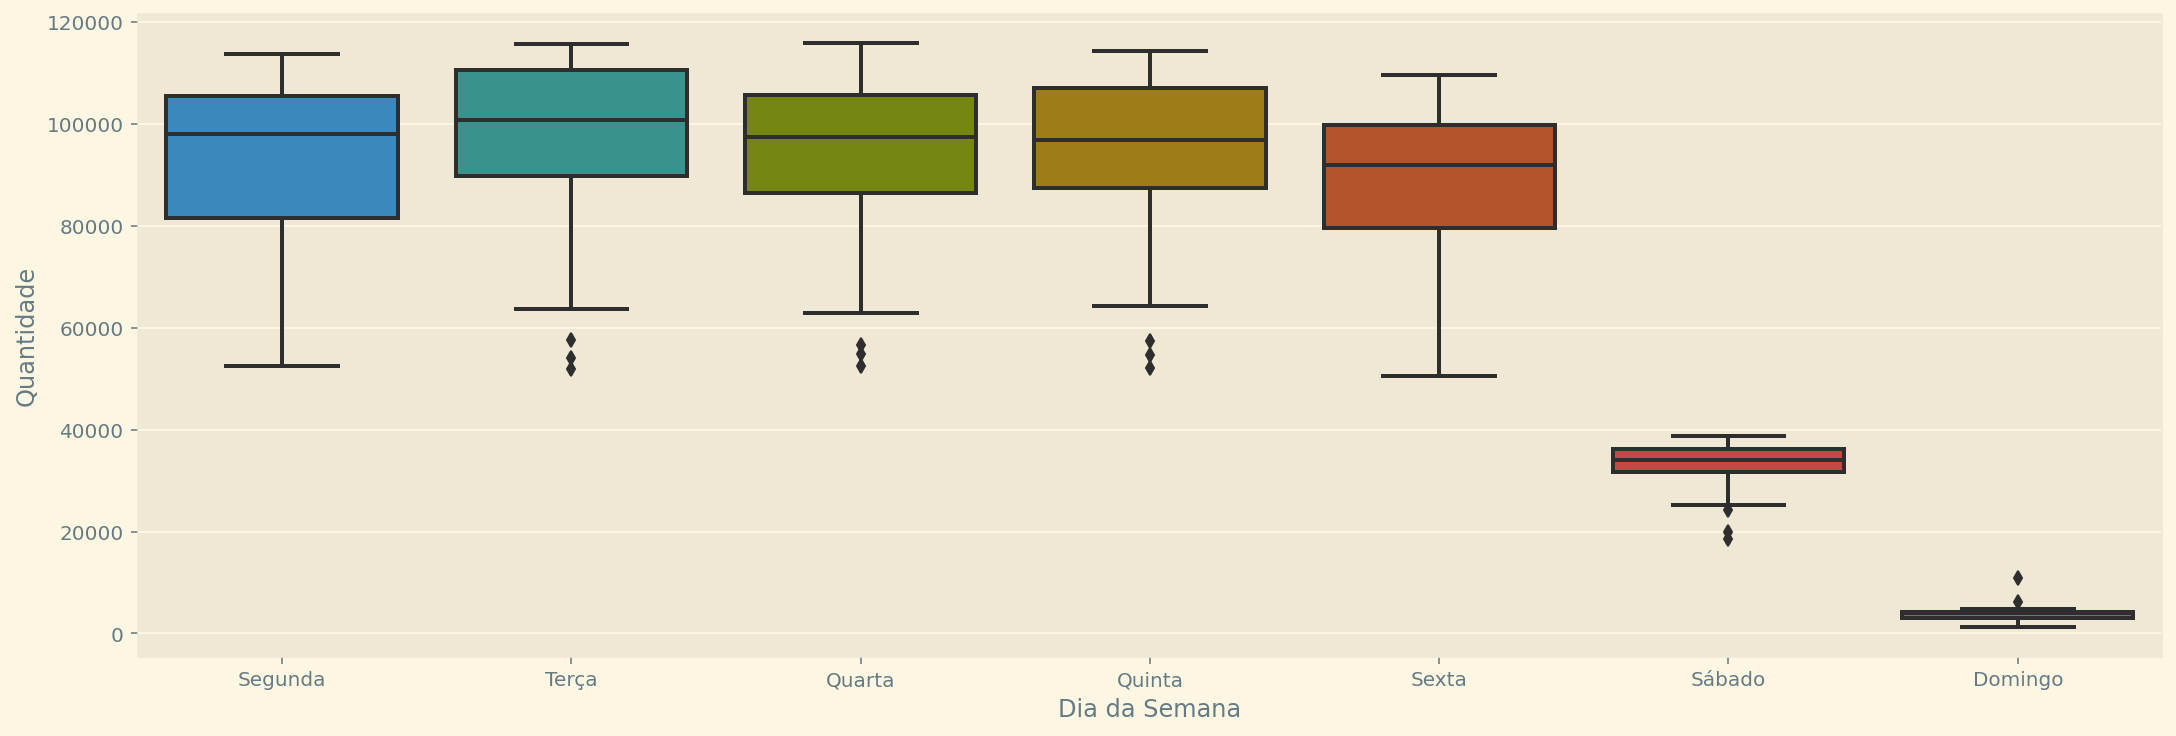

In [7]:
box_original1 = box_day(freq_pas)
box_original1

Diante dos dados outlies presentes provinientes dos feriados e aos dias sem contagem devido a greve, precisamos encontrar um forma de substituir esses valores. 

O procedimento adotado consiste em analisar a distribuição por dia da semana e realizar o teste de normalidade de Shapiro-will $(\chi^{2})$. Caso seja constatado a normalidade, o valor será substituído pela média, caso não haja normalidade, pela mediana.

O teste de $\chi^{2}$ tem como $H_{0}$ a normalidade dos dados e como $H_{1}$ a não normalidade. Para  valor de significância foi adotado o padrão de 0,05, o que significa um intervalo de confiança  de 95%.

Este método foi definido pois podemos identificar que existe um comportamento diferente para cada dia da semana, buscando não alterar a distribuição dos dados, realizamos uma análise que considera os dados em ralação a cada dia da semana. 

In [8]:
from scipy import stats


def shapiro_test_days():
    day_0 = freq_pas[freq_pas['dia_semana'] == 0]; shapiro_0 = stats.shapiro(day_0['Passageiros'])
    day_1 = freq_pas[freq_pas['dia_semana'] == 1]; shapiro_1 = stats.shapiro(day_1['Passageiros'])
    day_2 = freq_pas[freq_pas['dia_semana'] == 2]; shapiro_2 = stats.shapiro(day_2['Passageiros'])
    day_3 = freq_pas[freq_pas['dia_semana'] == 3]; shapiro_3 = stats.shapiro(day_3['Passageiros'])
    day_4 = freq_pas[freq_pas['dia_semana'] == 4]; shapiro_4 = stats.shapiro(day_4['Passageiros'])
    #filtrando sabado 
    day_5 = freq_pas.query("dia_semana == 5")
    shapiro_5 = stats.shapiro(day_5['Passageiros'])
    # teste para domingo 
    day_6 = freq_pas.query("dia_semana == 6")
    shapiro_6 = stats.shapiro(day_6['Passageiros'])
    df = pd.DataFrame({'pvalor': [shapiro_0.pvalue, shapiro_1.pvalue,
                                  shapiro_2.pvalue, shapiro_3.pvalue,
                                  shapiro_4.pvalue, shapiro_5.pvalue,
                                  shapiro_6.pvalue]})
    return(df.round(5))

shapiro_day = shapiro_test_days()
shapiro_day

,pvalor
0,0.00450
1,0.00062
2,0.00244
3,0.00114
4,0.00333
5,0.00022
6,0.00000


Outro obstáculo a ser superado consiste que há dias que não existem na tabela. Devido a greve, houve dias que não ocorreram registro de passageiro e não estão nem zerados. A solução encontrada foi construir um data.frame com todos os dias do ano até a última data de registro utlizada na análise, a data limite utilizada para construção da previsão. A segunda etapa consistiui em unir as tabelas e substituir valores `NA` por 0. Contruímos a função *full_days_2022()* para estre procedimento.

In [9]:
last_day = np.array(freq_pas['Data Coleta'])[-1]

def full_days_2022():
    # selecionando somente as variáveis com a data e o número de passageiros da tabela principal
    data_correect = freq_pas[['Data Coleta', 'Passageiros']]
    # criando uma vetor com todas as datas de 2022 até o último dia de análise
    days_2022 = pd.date_range(start = '2022-01-02', end =last_day) # não incluímos o dia 01/01 pq estava zerado
    # criando um data.frame com o vetor criado
    days_full = pd.DataFrame({'Data Coleta':days_2022})
    # transformando em days
    days_full['Data Coleta'] = pd.to_datetime(days_full['Data Coleta'], format='%Y-%m-%d')
    days_merge = pd.merge(days_full, data_correect, how = 'outer', on = 'Data Coleta')
    # zerando os days com "NA" e substituindo pela média
    days_merge['Passageiros'] = days_merge['Passageiros'].fillna(0)
    days_merge['dia_semana'] = days_merge['Data Coleta'].dt.dayofweek
    return(days_merge)

freq_pas = full_days_2022()

Com a tabela construída, com os valores 0, realizamos a alteração destes valores de acordo com os valores estabelicidos na tabela sem os valores irreais. O valor será substituído de acordo com teste de normalidade.

In [10]:
for i in range(7):
    if shapiro_day['pvalor'][i] > 0.05:
        freq_pas['Passageiros']  = np.where((freq_pas['Passageiros'] == 0 ) 
        & (freq_pas['dia_semana'] == i) 
        & (freq_pas['Data Coleta'] > '2022-01-31'), data_day_c['mean'][i], freq_pas['Passageiros'])
    
    else:                                     
        freq_pas['Passageiros']  = np.where((freq_pas['Passageiros'] == 0 ) 
        & (freq_pas['dia_semana'] == i) 
        & (freq_pas['Data Coleta'] > '2022-01-31'),data_day_c['50%'][i] , freq_pas['Passageiros'])

Para confirmar alteraçãos dos valores, vizuallizamos o box-plot novamente. Percebemos a correção implantanda. 

O segundo gráfico  mostra  a linha temporal corrigida. 

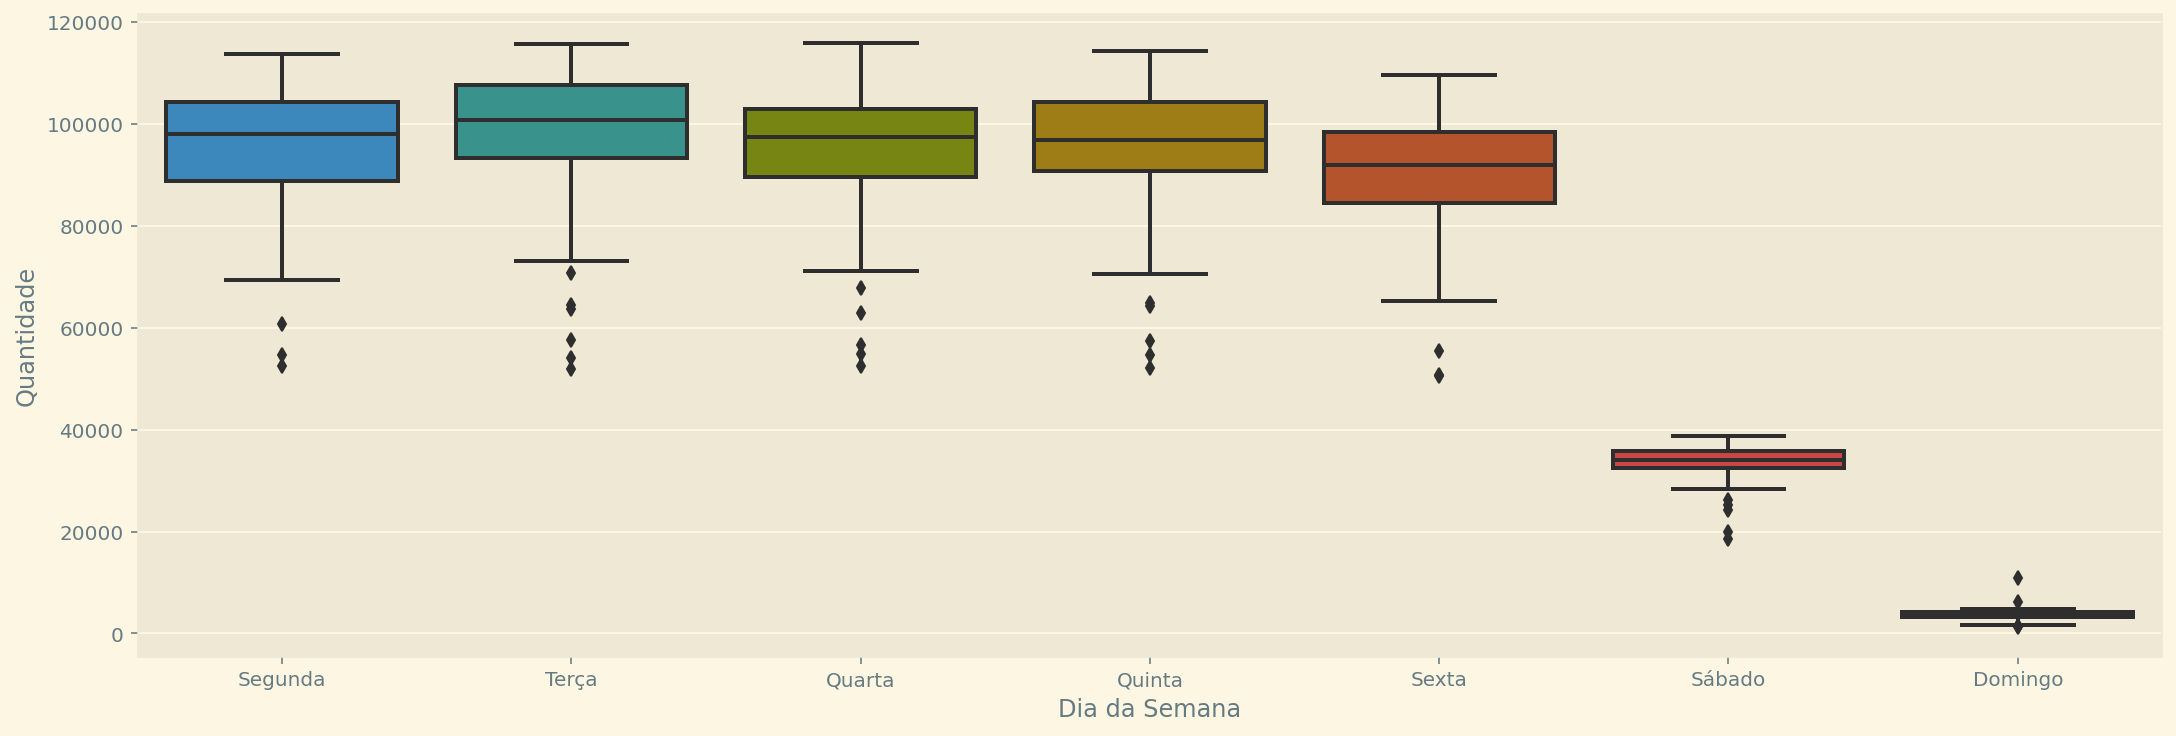

In [11]:
# refazendo o boxplot para analisar se foram retirados os otlines

box_correct = box_day(freq_pas)
box_correct

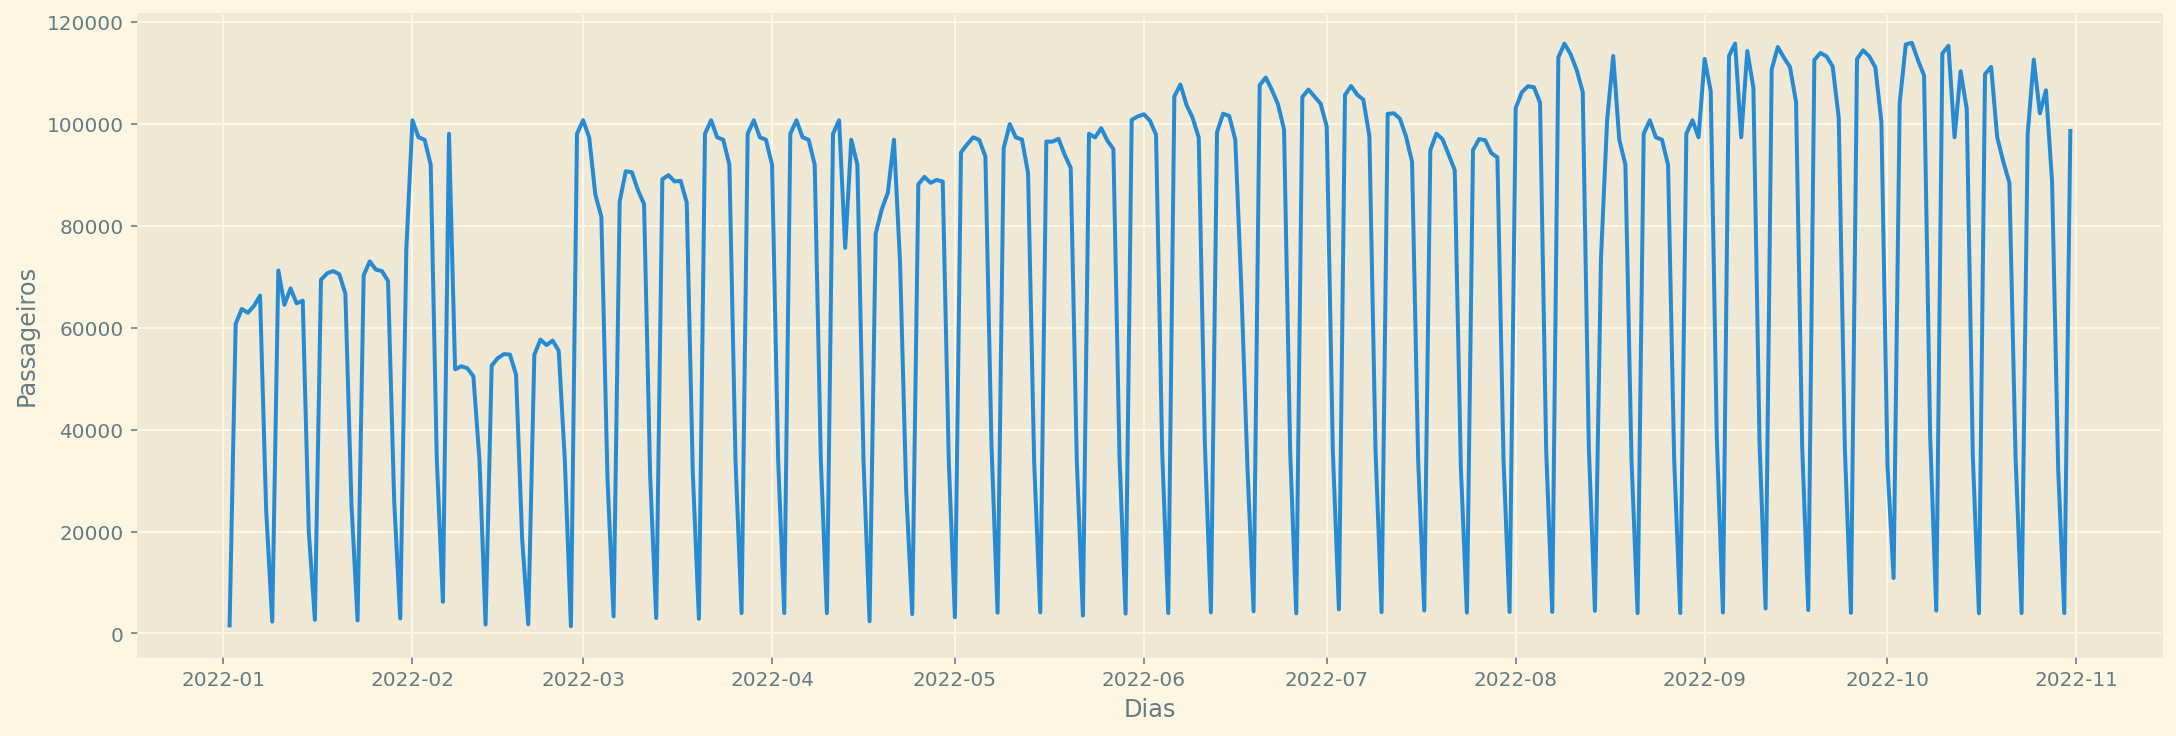

In [12]:
# gráfico com a vizualização da linha do tempo de 2022 com as data corrigidas 
plot_ts()

Podemos perceber que na série original que na parte final do período analisado, referente ao mês de outubro, há um comportamento  atípico e sem o padrão configurado as datas anteriores. Devido as eleições e número de feriados, o compotarmento da série é alterado o que resulta em valores de erros maiores. 

Para os modelos de previsão, iremos utilizar a série corrigida que ainda apresenta um comportamento influenciado pelas oscilações não previstas, só que em um grau menor, todavia, após um período mensal, é importante realizar a construção de outro modelo de previsão da série e avaliar as mundanças no modelo criado.

Outro processo futuro é a acompanhar a estabilização da frequência de passageiros. Podemos ver no gráfico que há uma diferença nos valores de passageiros comparando primeiro e segundo semestre, resultado de um aumento de pessoas transportadas. No segundo semestre, os passageiros, em dias úteis superam os 100 mil, todavia, esse comportamento só se estabilizou em maio e ocorreu outro incremento a partir de agosto, onde os valores se aproximam dos 120 mil passageiros. 

# Previsão de passageiros

## Séries Temporais

Com a correção da série de passageiros, podemos realizar um modelo de previsão para o transporte público de Teresina. Para isto, iremos utilizar, numa primeira análise, com séries temporais, o modelo Arima com Sazonalidade, SARIMA.

Na segunda fase, iremos utilizar Rede Neurais, do tipo Recorrente, apropriada para realizar estimar estimações para séries temporais. 


Para séries temporais, o processo é um pouco exigente devido a existência de pressupostos para a criação de modelos de previsão utlizando ARIMA.

Temos que testar a série em relação a sua estacionariedade (média constante e dependência da função de autocovariância dependente somente do tempo).

Pelo comportamento do gráfico, fica claro que existe a sazonalidade, direcionando para o uso de um modelo SARIMA. 

Iremos realizar os testes para verificar a cumprimento dos pressupostos e, caso não seja cumprido, iremos realizar a diferença ($X_{t} - X_{t-1}$), para conseguir deixar a série estacionária

Uma das abordagens de séries temporais é que podemos realizar a divisão da série temporal em três elementos:

- Tendência
- Sazonalidade
- Erro

Tendência consiste no comportamento puro da série e conseguimos enxergar a direção que a série segue, podendo ser de alta, baixa ou de estabilidade

Sazonalidade indica a repetição do processo em relação ao seu funcionamento, após uma quantidade t de períodos, a série repete seu comportamento. 

Os erros são os movimentos que não são captados nos pela tendência e pela sazonalidade. Consiste no aspecto aletório da séries.

No gráfico abaixo, o comportamento da série e as três partes isoladas.

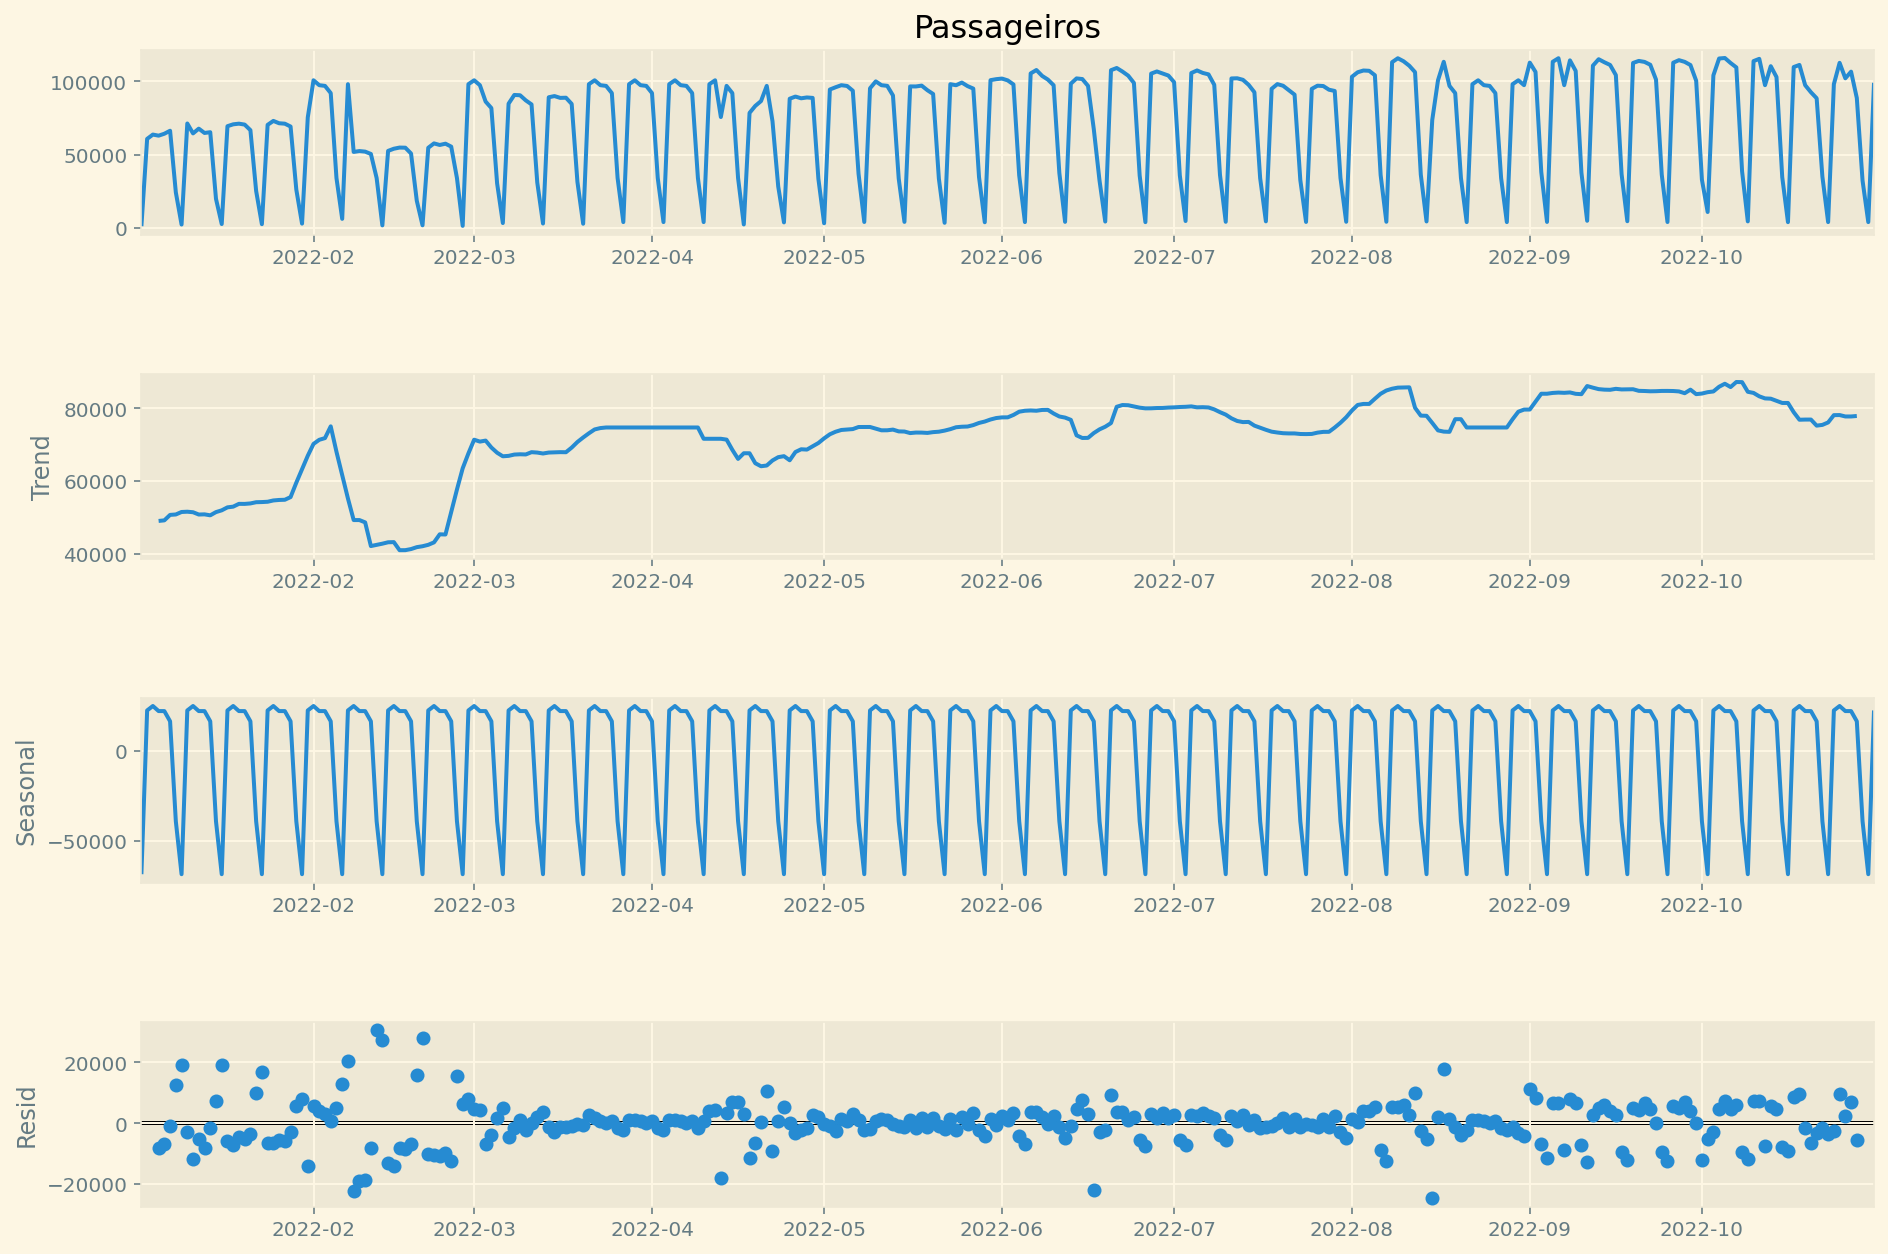

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# def decompose():
freq_pas.index = pd.to_datetime(freq_pas['Data Coleta'])
freq_pas = freq_pas.drop(columns=['Data Coleta', "dia_semana"])
result = seasonal_decompose(freq_pas['Passageiros'], period = 7,  model='additive')
fig = result.plot()
fig.set_size_inches(15,10)
fig.show()


Após identificar os componentes da série, podemos realizar o teste de estacionariedade para descobrimos se iremos precisar de alguma transformação para possibilitar a criação do modelo.

A função abaixo foi adaptada para nosso trabalho e auxilia na análise. No teste de Fuller, com intervalo de confiança de 95%, o p-valor menor que 0,05 indica a série estacionária. 

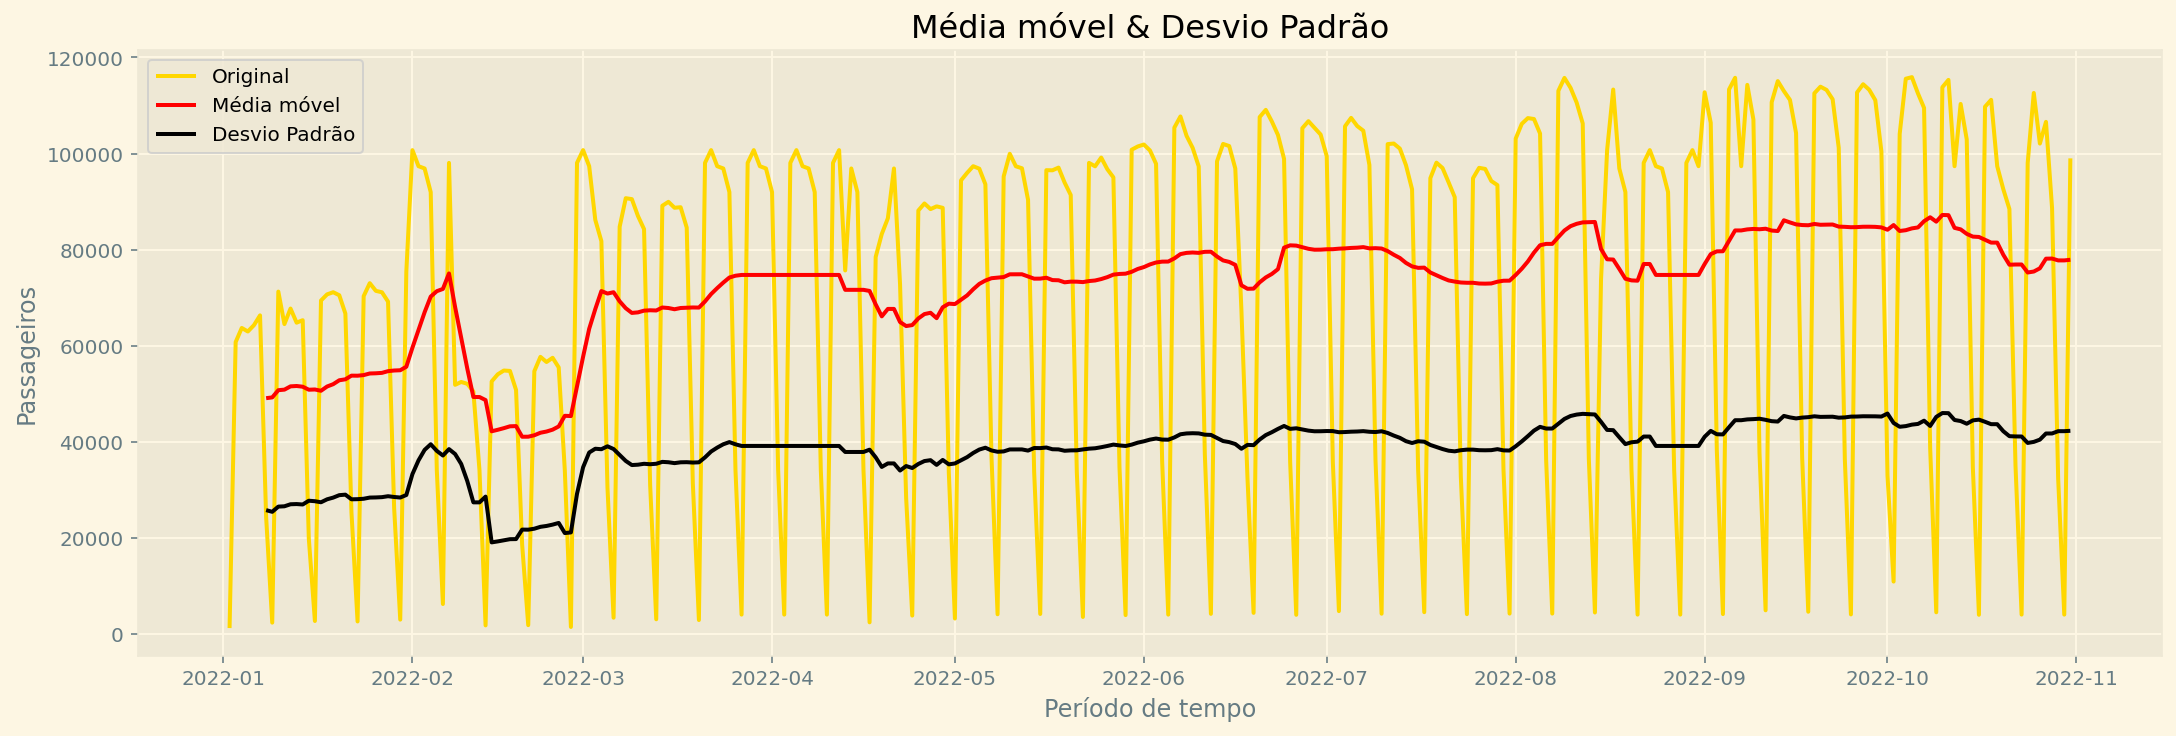

Test Statistic                  -2.564933
p-value                          0.100464
#Lags Used                      14.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64


In [14]:
from statsmodels.tsa.stattools import adfuller

# Função baseada no código em: https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

def test_stationarity(timeseries, t):

    rolmean = timeseries.rolling(t).mean()
    rolstd = timeseries.rolling(t).std()

#Plot rolling statistics:
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15,5)
    plt.plot(timeseries, color='gold',label='Original')
    plt.plot(rolmean, color='red', label='Média móvel')
    plt.plot(rolstd, color='black', label = 'Desvio Padrão')
    plt.legend(loc='best')
    plt.title('Média móvel & Desvio Padrão')
    plt.xlabel("Período de tempo")
    plt.ylabel('Passageiros')
    plt.show()
    #Perform Dickey-Fuller test:
    #print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(freq_pas['Passageiros'],7)

Concluímos que a série não é estacionária com um p-valor > 0,05 e, dessa forma, teremos que aplicar pelo menos uma diferença na série. Aplicando a funções para saber quantas diferenças serão necessárias, aplicamos conjutamente para detectar a necessidade de aplicarmos a diferença sazonal.

In [15]:
from pmdarima.arima import nsdiffs, ndiffs


def diff(x, i):
    dif1 = ndiffs(x)
    dfis = nsdiffs(x, m = i)
    df_est = pd.Series([dif1 ,dfis], index =[ "Diferenças", "Diferenças Sazonais"])
    display(df_est)

diff(freq_pas['Passageiros'], 7)

Diferenças             1
Diferenças Sazonais    1
dtype: int64

Concluímos que somente uma diferença é suficiente para estacionar a série. Com essa informação, aplicamos o comando `np.diff` para realizar o procedimento de uma diferença. Temos a informação complementar uma diferença sazonal pode deixar a série estacionária. 

Nos gráficos a seguir, vemos o comportamento da série com uma diferença e a informação confirmada (p-valor) que a série é estacionária. 

p-valor - 1 diferença:  9.069933423043197e-07


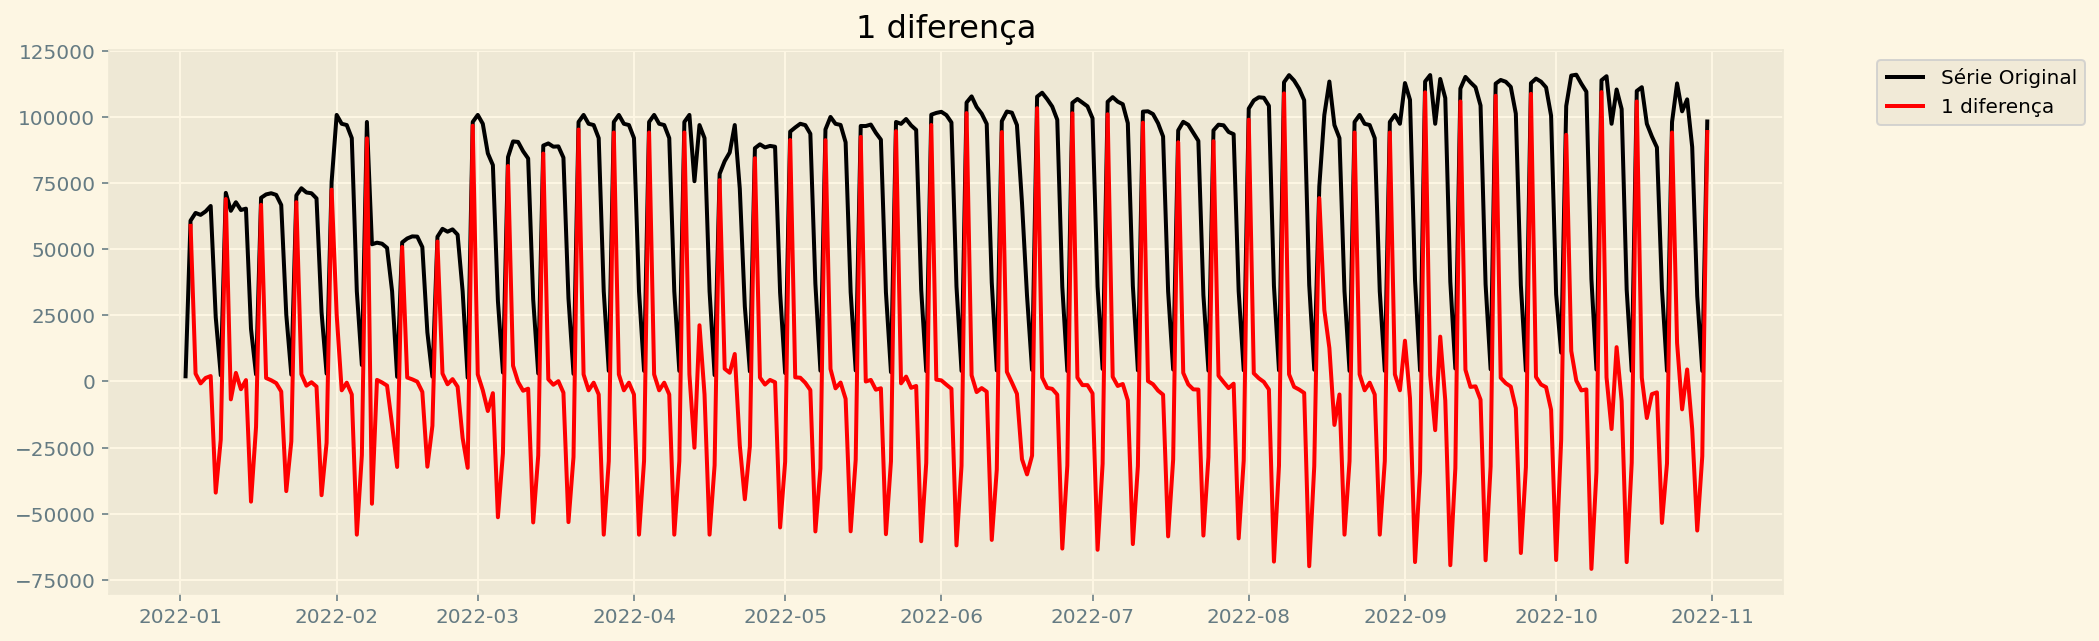

In [16]:
def dif_1():
    fig, ax = plt.subplots(figsize = (15,5), sharex = True)
    ax.plot(freq_pas['Passageiros'], label='Série Original', color='black')
    ax.plot(freq_pas['Passageiros'].diff(1), label='1 diferença', color='red')
    ax.set_title('1 diferença')
    ax.legend(bbox_to_anchor=(1.05, 1.0), fontsize=10)
    diff_pas_1 = np.diff(freq_pas['Passageiros'], 1)
    print('p-valor - 1 diferença: ', adfuller(diff_pas_1)[1])

dif_1()

Com a série estacionariedade, podemos construir os gráficos de autocorrelação e correlação parcial para poder identificar qual é o possível modelo que podemos construir:

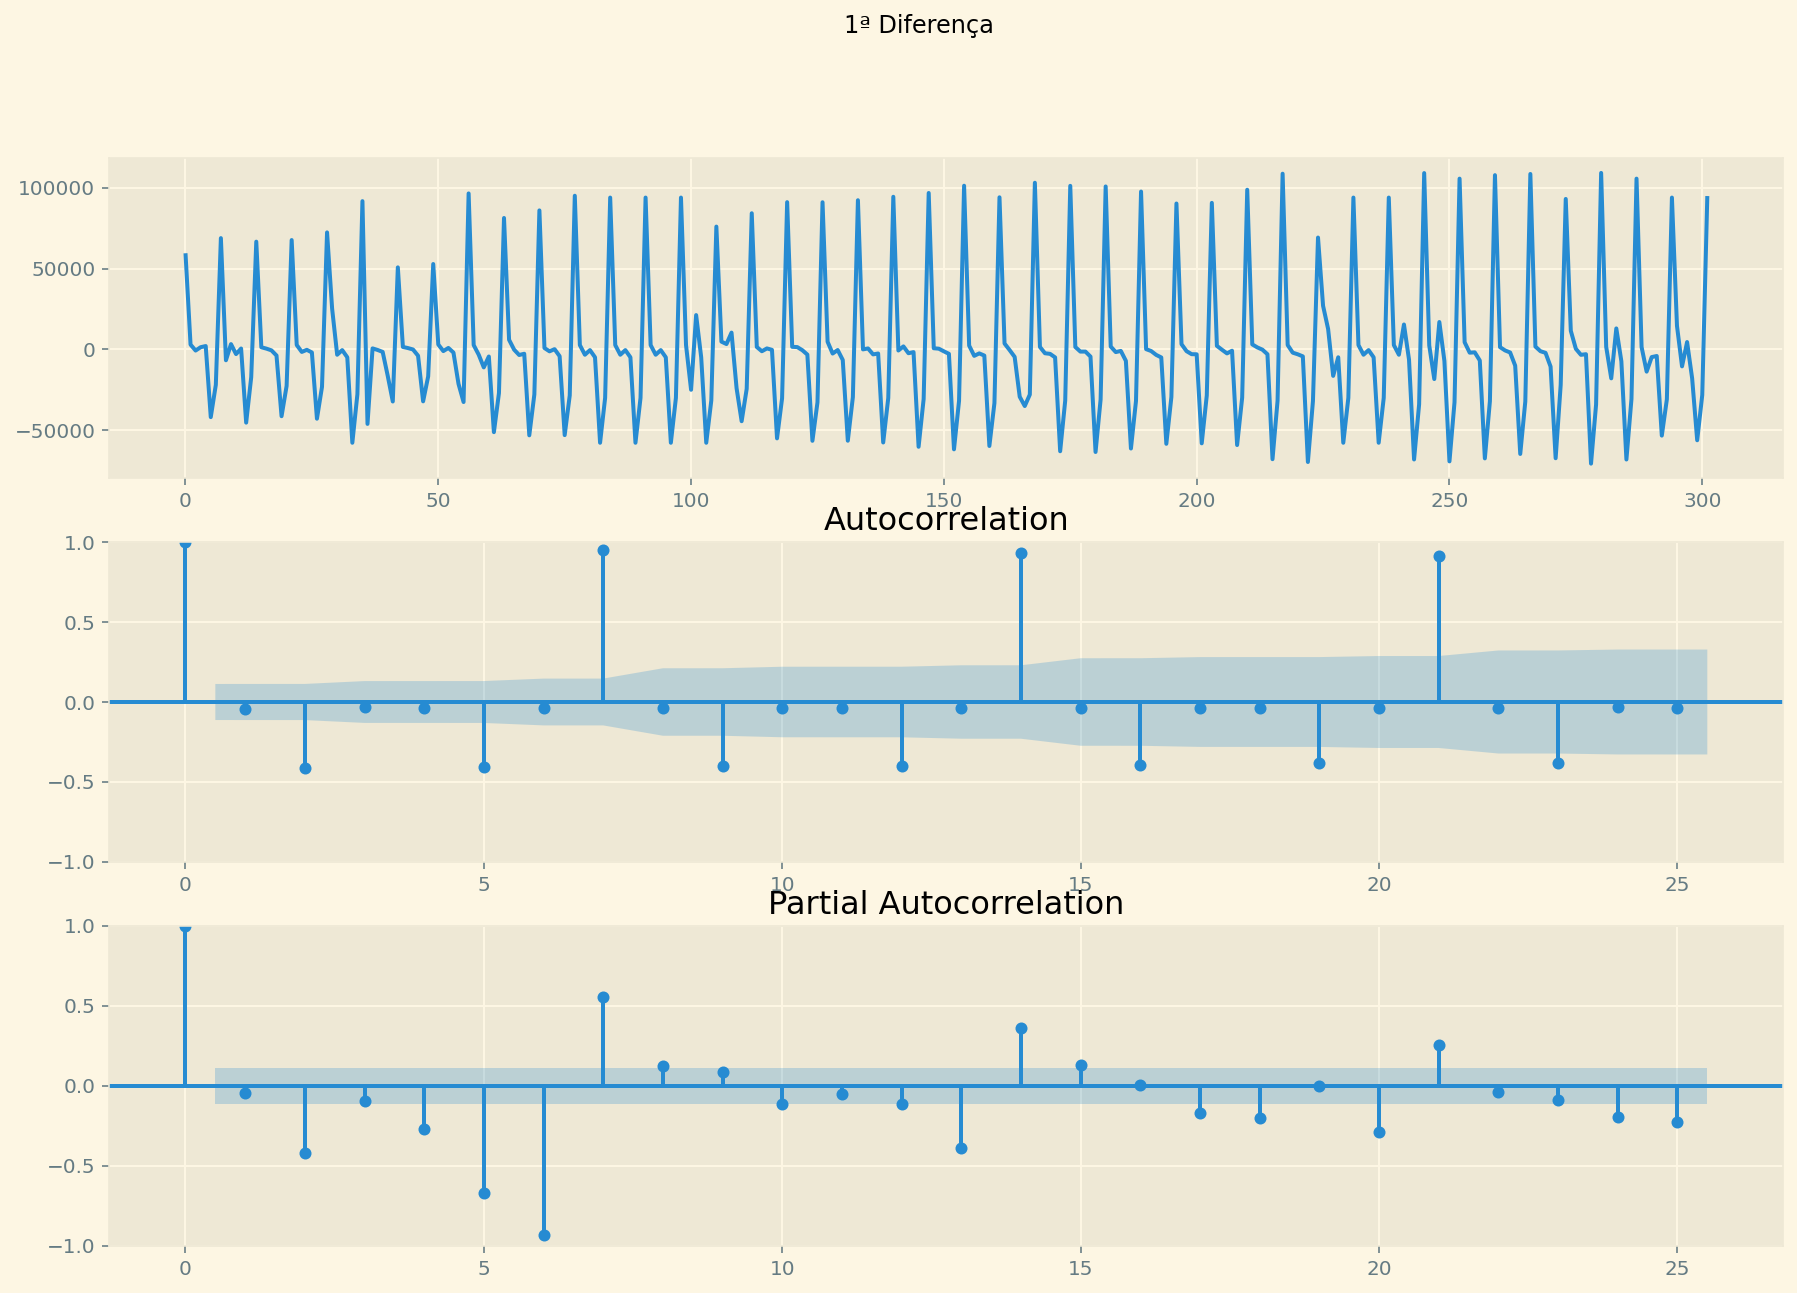

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
diff_pas_1 = np.diff(freq_pas['Passageiros'], 1)

def graficos_series():
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.suptitle('1ª Diferença')
    fig.set_size_inches(15,10)
    ax1.plot(diff_pas_1)
    plot_acf(diff_pas_1, ax = ax2)
    plot_pacf(diff_pas_1, ax = ax3)
    plt.show()

graficos_series()

O gráficos não permitem um diagnóstico claro de qual modelos podemos utilizar para séries temporais. Para auxíliar, iremos utilizar a função auto-arima  para testar vários modelos.

Realizamos uma divisão em 80% para treino e 20% para teste. A mesma divisão será utilizada para Redes Neurais para podermos comparar os resultados.

Abaixo, temos o procedimento de divisão da série aplicação da função auto-arima

In [18]:
data = freq_pas['Passageiros']

test_size = int(0.2*len(data))
train, test = data[:-test_size], data[-test_size:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((243,), (243,), (60,), (60,))

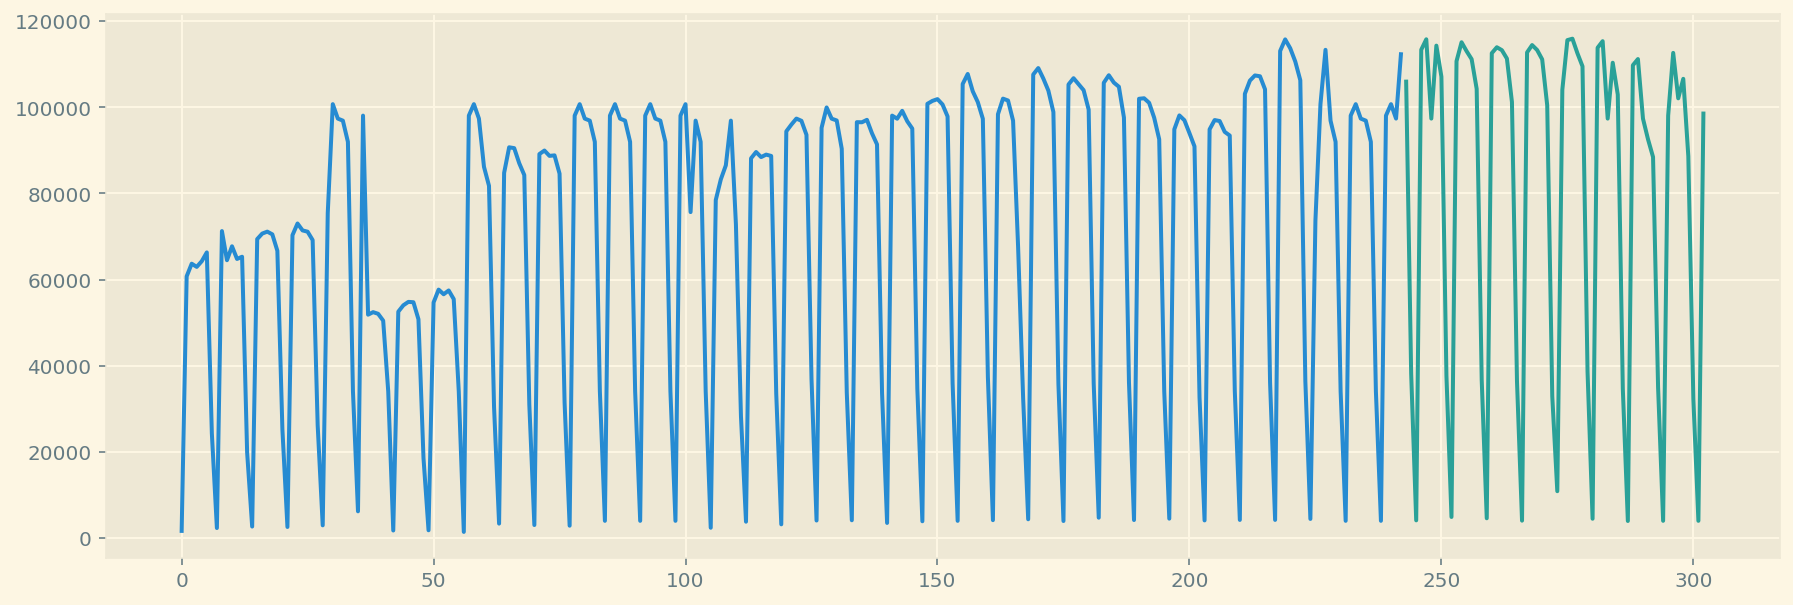

In [19]:
def plot_ts2():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(x_train, train)
    ax.plot(x_test, test)

plot_ts2()

In [20]:
# pip install pmdarima
import pmdarima as pm

model_auto = pm.auto_arima(train, start_p=1, start_q=1,
                    #   exogenous=df[['seasonal_index']],
                      test='adf',
                      max_p=7, max_q=7,
                      m=7,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=4951.857, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5044.841, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=4986.372, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=4956.069, Time=0.26 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=5005.208, Time=0.56 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=4953.698, Time=0.70 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=4953.676, Time=0.56 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=4972.152, Time=0.29 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=4955.624, Time=1.48 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=4966.849, Time=0.25 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=4952.285, Time=0.43 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=4953.194, Time=0.47 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=4970.363, Time=0.10 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=4951.613, Time=0.23 sec
 ARIMA(0,1,2)(0,1,0)[7]          

In [21]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  243
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 7)   Log Likelihood               -2464.265
Date:                             Fri, 10 Mar 2023   AIC                           4942.530
Time:                                     15:57:56   BIC                           4966.747
Sample:                                 01-02-2022   HQIC                          4952.293
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5468      0.544      1.005      0.315      -0.519       1.613
ar.L2          0.2888      0.451      0.640      0.522      -0.596       1.174
ma.L1         -0.9320      0.547     -1.704      0.088      -2.004       0.140
ma.L2         -0.2850      0.657     -0.434      0.664      -1.572       1.002
ma.L3          0.2298      0.137      1.683      0.092      -0.038       0.497
ma.S.L7       -0.6256      0.048    -13.038      0.000      -0.720      -0.532
sigma2      9.187e+07   3.28e-08    2.8e+15      0.000    9.19e+07    9.19e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               598.64
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+31. Standard errors may be unstable.
"""

No gráfico abaixo temos a comparação com o período de teste e o erro quadrático médio, medida que funciona para calcularmos o nível de erro e realizar comparações de modelos.

c:\Users\Filipe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Filipe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


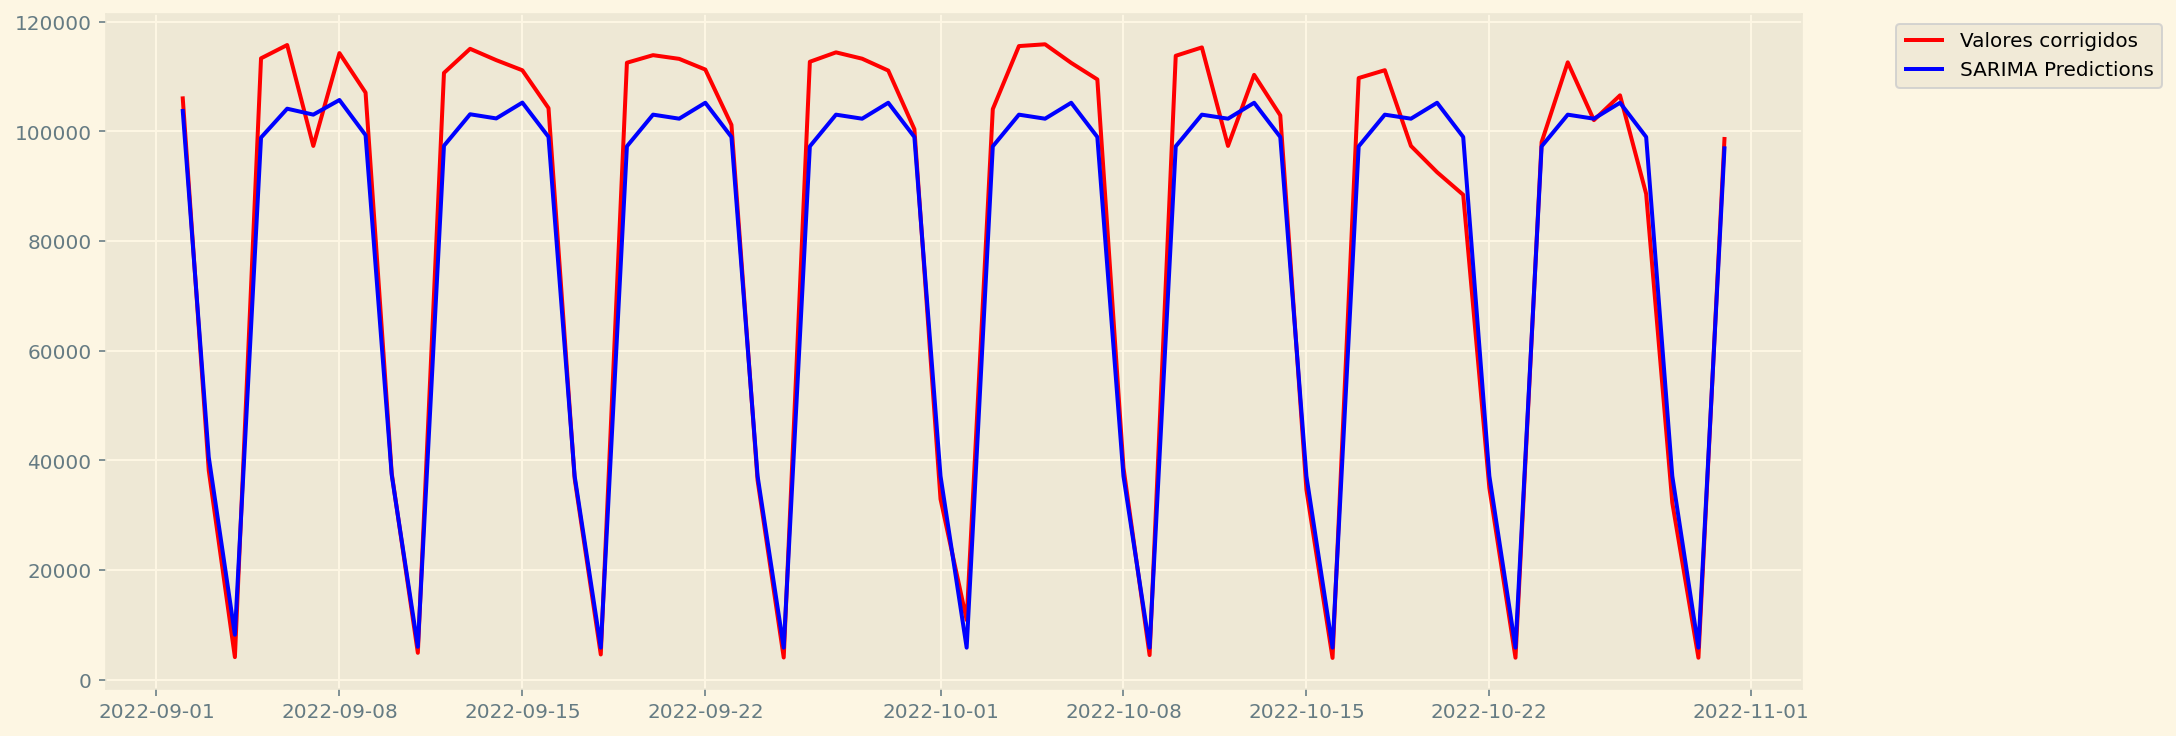

Raiz do EQM: 8090.06


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

model_sarima = SARIMAX(train, model =  model_auto.order, seasonal_order = model_auto.seasonal_order)
model_sarima = model_sarima.fit()

y_pred = model_sarima.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df['Predictions'] = model_sarima.predict(start = y_pred_df.index[0], 
                                                end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(15, 5)
plt.plot(test, color = "red", label = 'Valores corrigidos')
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
testScore = mean_squared_error(test, y_pred_out, squared = False)
print('Raiz do EQM: %.2f' % (testScore))

## Rede Neurais

Para criação de um modelo de previsão de séries temporais com redes neurais. O processo é mais direto, pois não precisamos realizar nenhuma alteração nos dados para adequação de pressuposto, pois não tem. 

Implantamos o código necessário para criar o modelo e o próprio funcionamento da rede neural irá definir o modelo. *Equivale a usar o auto-arima sem a necessidade de observar a necessidade de diferenças.*

Para o processo de previsão para uma série temporal, as redes neurais recorrentes são mais utilizadas pois utilizam os dados ordenados, armazenando e comparados os resultados, para estruturar a rede neural. 

Um avanço para rede neural recorrente é a LSTM, onde o existe uma célula exclusiva para armazenamento e fluxo de memória, informação que poderia ser perdida numa RNN **simples**

In [23]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

# semente de aleatoriedade
tf.random.set_seed(4)

# tranformando a escala
sc = MinMaxScaler(feature_range = (0, 1))
dataset = freq_pas.values

# del freq_pas['day']

# transformando a séries
dataset  = sc.fit_transform(freq_pas)
# dataset = dataset.astype('float32')

# dividindo a séries para teste e treino na proporção 80/20
train_size = len(dataset) - test_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# criando rrays para a análise
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# criando arrays
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# # Instantiate the model 
model = Sequential()
# first layer
model.add(LSTM(90, activation='relu', input_shape=(1, look_back), return_sequences = True))
#second layer 
model.add(LSTM(90, activation='relu', input_shape=(1, look_back)))
#output layer
model.add(Dense(1, activation = 'relu'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

243 60
Epoch 1/100
241/241 - 4s - loss: 0.1536 - 4s/epoch - 15ms/step
Epoch 2/100
241/241 - 1s - loss: 0.0874 - 855ms/epoch - 4ms/step
Epoch 3/100
241/241 - 1s - loss: 0.0851 - 720ms/epoch - 3ms/step
Epoch 4/100
241/241 - 1s - loss: 0.0850 - 633ms/epoch - 3ms/step
Epoch 5/100
241/241 - 1s - loss: 0.0854 - 795ms/epoch - 3ms/step
Epoch 6/100
241/241 - 1s - loss: 0.0847 - 875ms/epoch - 4ms/step
Epoch 7/100
241/241 - 1s - loss: 0.0841 - 708ms/epoch - 3ms/step
Epoch 8/100
241/241 - 1s - loss: 0.0842 - 554ms/epoch - 2ms/step
Epoch 9/100
241/241 - 1s - loss: 0.0836 - 512ms/epoch - 2ms/step
Epoch 10/100
241/241 - 1s - loss: 0.0823 - 584ms/epoch - 2ms/step
Epoch 11/100
241/241 - 1s - loss: 0.0823 - 574ms/epoch - 2ms/step
Epoch 12/100
241/241 - 1s - loss: 0.0822 - 572ms/epoch - 2ms/step
Epoch 13/100
241/241 - 1s - loss: 0.0817 - 547ms/epoch - 2ms/step
Epoch 14/100
241/241 - 1s - loss: 0.0813 - 570ms/epoch - 2ms/step
Epoch 15/100
241/241 - 1s - loss: 0.0799 - 593ms/epoch - 2ms/step
Epoch 16/100
2

In [24]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = sc.inverse_transform(trainPredict)
trainY = sc.inverse_transform([trainY])
testPredict = sc.inverse_transform(testPredict)
testY = sc.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 3ms/step
Train Score: 21230.03 RMSE
Test Score: 28390.92 RMSE


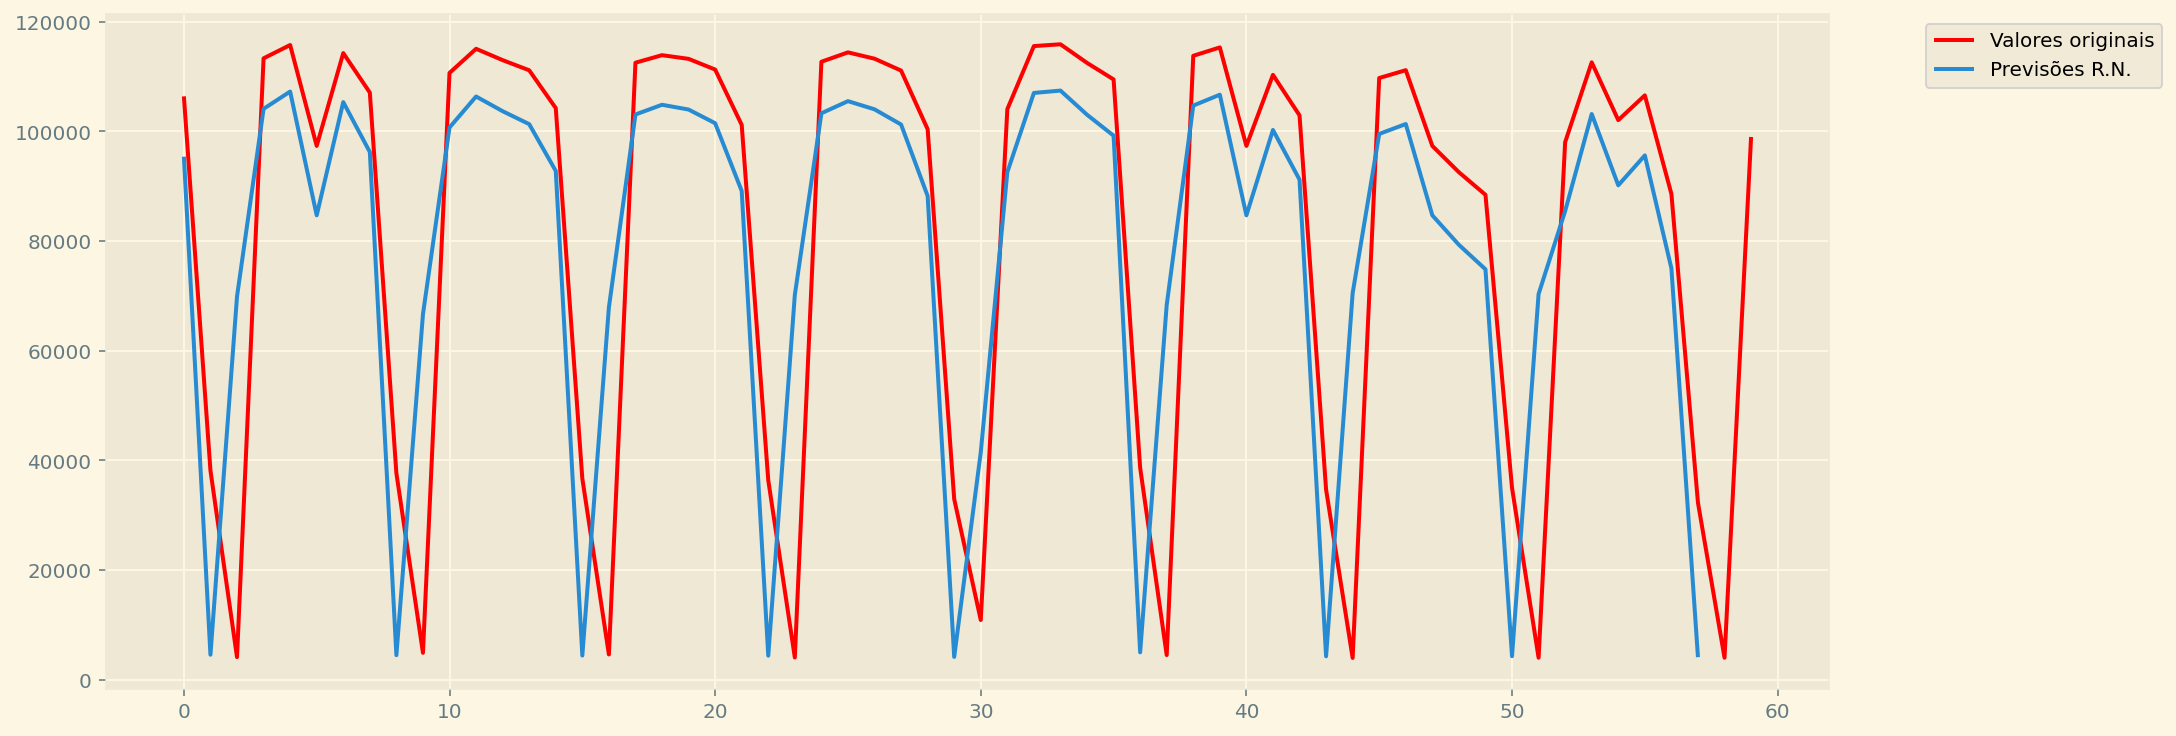

Raiz do EQM: 28390.92


In [25]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# gráfico comparando os dados respostas e os dados origianis 
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(15, 5 )
plt.plot(sc.inverse_transform(dataset[-test_size:]),color = "red", label = 'Valores originais')
# plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[-test_size  +1 :], label = 'Previsões R.N.')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
testScore = mean_squared_error(testY[0], testPredict[:,0], squared = False)
print('Raiz do EQM: %.2f' % (testScore))

## Comparando séries Temporais e Rede Neurais

Depois de aplicados os modelos na série, é importante realizarmos uma análise para determinar qual modelo é o mais eficiente. No gráfico abaixo, temos a séries original e as séries resultantes dos modelos definidos através da autoarima e a rede neural.

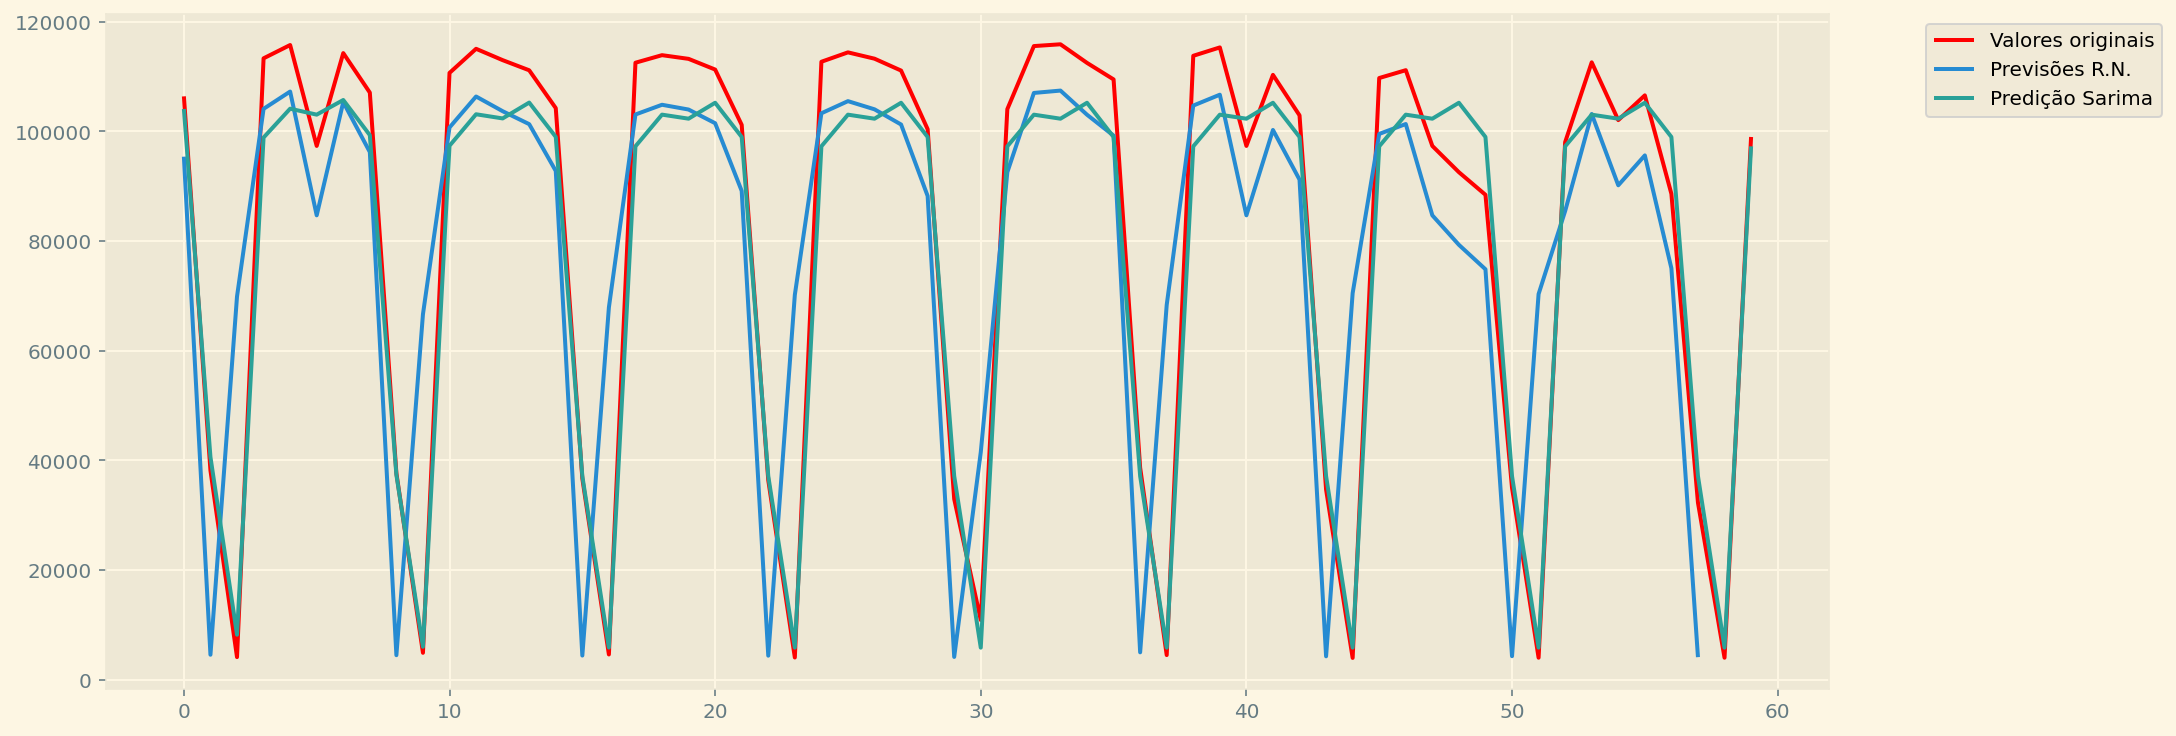

In [26]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(15, 5 )
plt.plot(sc.inverse_transform(dataset[-test_size:]),color = "red", label = 'Valores originais')
# plt.plot(trainPredictPlot)
plt.plot(testPredict[:,0], label = 'Previsões R.N.')
plt.plot(np.array(y_pred_out), label = 'Predição Sarima')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Podemos notar que o modelo de séries temporais funcionou melhor para previsão de transporte de passageiros.

Para o período que temos analisando até agora, o modelo séries temporais foi o que se saiu o melhor, com um menor valor da raiz do EQM: 8090.6

# Previsão arrecadação de passagens

Com a previsão de passageiros construída, um próximo passo é a realização de uma previsão do valores recebidos com o pagamentos de passagens. No sistema de transposte público de Teresina, há passageiros que pagam a totalidade da passagem, que está no valor de `R$ 4,00`. Estudantes tem o direito de meia-passagem, que está no valor de `R$ 1,35`. Há também que tem o direito a gratuidade, logo não interferem no valor arrecado.

No gráfico abaixo, visualizamos pelos tipos de passageiros, que somente 15,8% dos passageiros possuem a gratuidade, passageiros que pagam o valor total corresponde a 65,2% (Inteiras, VT e VT integração) e passageiros com direito a meia-passagem correspondem a 19% (Estudantes e Estudantes Integração). 

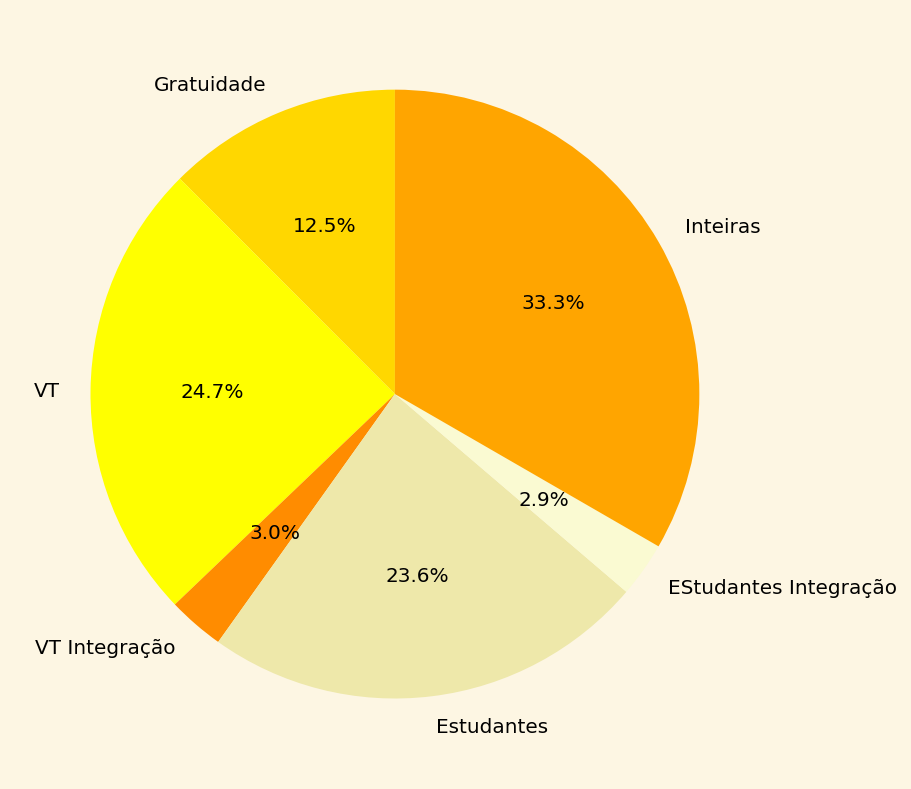

In [27]:
# cores do gráfico
colors = ( "Gold", "Yellow", "DarkOrange",
          "PaleGoldenrod", "LightGoldenrodYellow", "Orange")


# construção do gráfico
def type_pas():
    type_pas = df.query("Passageiros < 5000")[['Gratuidade', 'VT', 'VT Integração', 'Estudantes', 'EStudantes Integração', 'Inteiras']].agg('sum').to_frame().reset_index()
    type_pas = type_pas.rename(columns={"index": "Passageiro", 0: "Quantidade"})
    fig1, ax = plt.subplots()
    fig1.set_size_inches(7, 7)
    ax.pie(type_pas['Quantidade'], labels = type_pas['Passageiro'], autopct='%1.1f%%', startangle=90, colors=colors)
    # ax.axis('equal')
    plt.show()

type_pas()

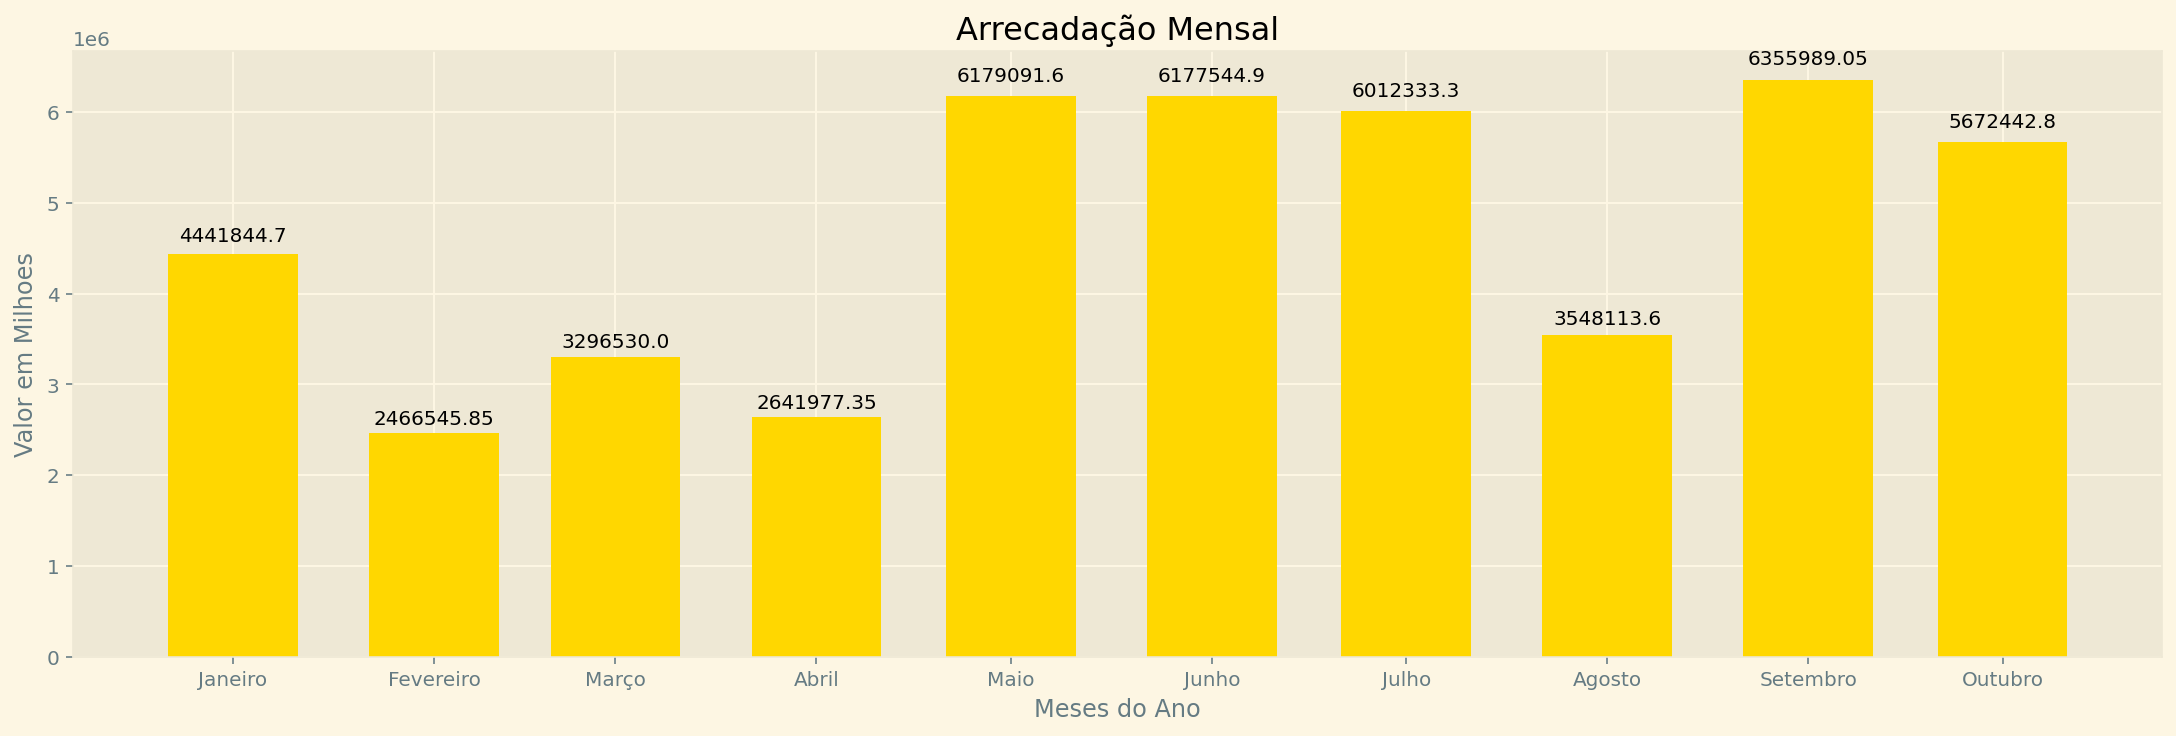

In [28]:
from matplotlib.pyplot import bar_label


def arrecada_mensal():
    # tratando os dados
    pas_month = df[df['Passageiros'] <= 5000] # filtro pra retirar valores irreais
    pas_month['Data Coleta'] = pd.to_datetime(pas_month['Data Coleta'], format='%Y-%m-%d')
    pas_month['Data Coleta'] = pd.to_datetime(pas_month['Data Coleta']).apply(lambda x: x.replace(day = 1))
    pas_month = pas_month.groupby('Data Coleta')['Valor Passageiros'].agg('sum')
    pas_month = pas_month.reset_index()    
    
    # contruindo gráfico
    fig, ax =  plt.subplots(constrained_layout=True)
    bar_plot = plt.bar(pas_month['Data Coleta'], pas_month['Valor Passageiros'],  color=['gold'], width = 20)
    fig.set_size_inches(15, 5)
    plt.title("Arrecadação Mensal")
    ax.set_ylabel('Valor em Milhoes')
    ax.set_xlabel('Meses do Ano')
    ax.set_xticklabels(["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"])
    
    # valores acima das colunas
    def autolabels(rects):
        for idx, rect in enumerate(bar_plot):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
            pas_month['Valor Passageiros'][idx],
            ha= 'center', va= 'bottom',rotation = 0)


    autolabels(bar_plot)
    plt.show()

arrecada_mensal()

A ideia original era utilizar uma regressão linear para realizar a previsão orcamentária. Quando visualizamos o gráfico de correlação linear a seguir para todo o intervalo de passageiros, vemos que um comportamento quase perfeito para regressão linear. O índice de determinação é 0.99, melhor impossível. Todavia, nem tudo é tão lindo como parece. Existem os pressupotos. 

Os presupostos para Regressão linear são:

- Linearidade dos dados
- Resíduos independentes
- Resíduos ~ N(0,$\sigma^{2}$)
- Homoscedacidade dos dados (variância constante)

No gráfico abaixo e podemos vizualizar toda a série no gráfico a seguir:

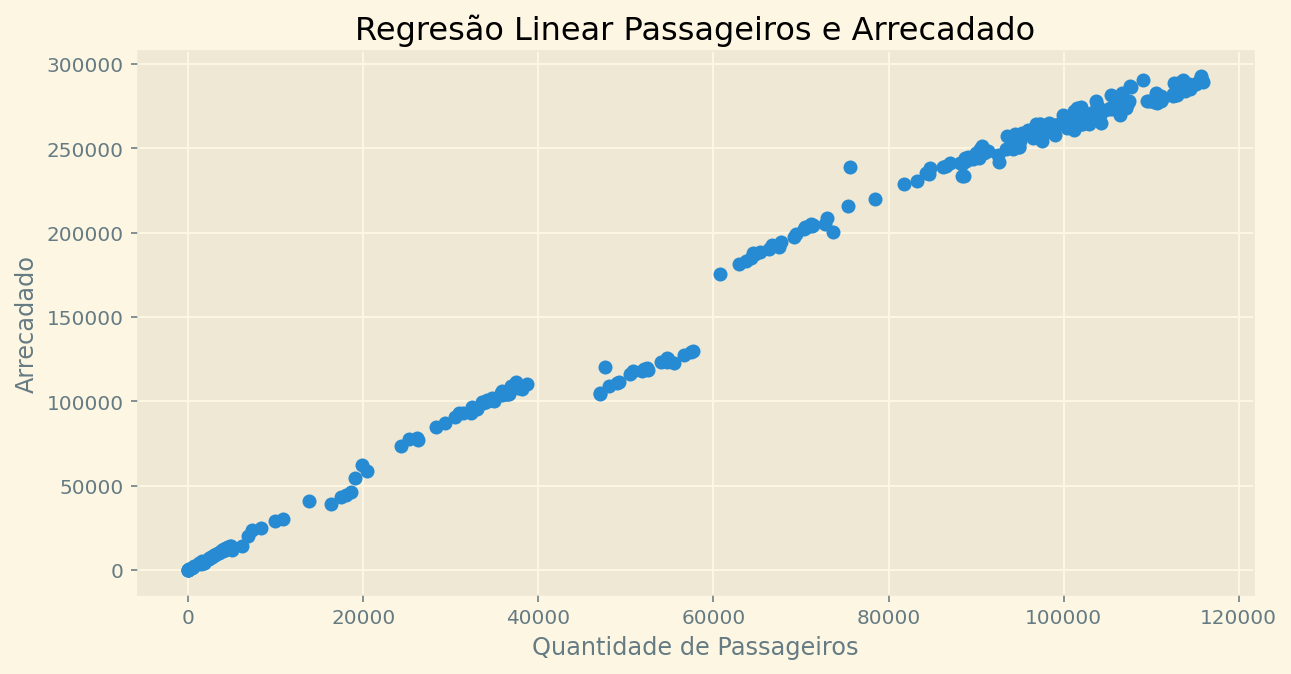

Correlação    0.995448
dtype: float64


In [29]:
import scipy.stats

previ_financial = df.groupby('Data Coleta')[['Passageiros', 'Valor Passageiros']].agg('sum').reset_index()


def graph_cor():
    fig, axs = plt.subplots(sharey=True)
    fig.set_size_inches(10,5)
    plt.scatter(x = previ_financial['Passageiros'], y = previ_financial['Valor Passageiros'])
    plt.title("Regresão Linear Passageiros e Arrecadado")
    plt.xlabel("Quantidade de Passageiros")
    plt.ylabel("Arrecadado")
    
    plt.show()
    reg_pas = scipy.stats.pearsonr(previ_financial['Passageiros'], previ_financial['Valor Passageiros'])
    df_reg = pd.Series(reg_pas[0], index = ["Correlação"])
    print(df_reg)

graph_cor()

Com a configuração linear construída, o próximo passso é realizar a estimação dos parâmetros, deve-se que obter os valores estimados de $B_{0}$, que corresponde ao intercepto da função e $B_{1}$, que consiste no coeficiente linear. A função deve ter o seguinte formato:

$$y_{i} = B_{0} + B_{1}x_{i} + e_{i}$$

O elemento $e_{i}$ corresponde ao erro, o que corresponde a diferença do valor real e estimado. O código abaixo analisa se a modelo está sastifazendo todos os pressupostos e poderemos concluir se é possível utilizar esse modelo mais simples.

### Análise do modelo Regressivo

Média dos Resíduos 2.1166422150351783e-12
Normalidade dos Resíduos: 0.0001642941206227988
Teste de Indepedência: [2.05275891]
Teste de Homocestacidade: 0.477290501387857


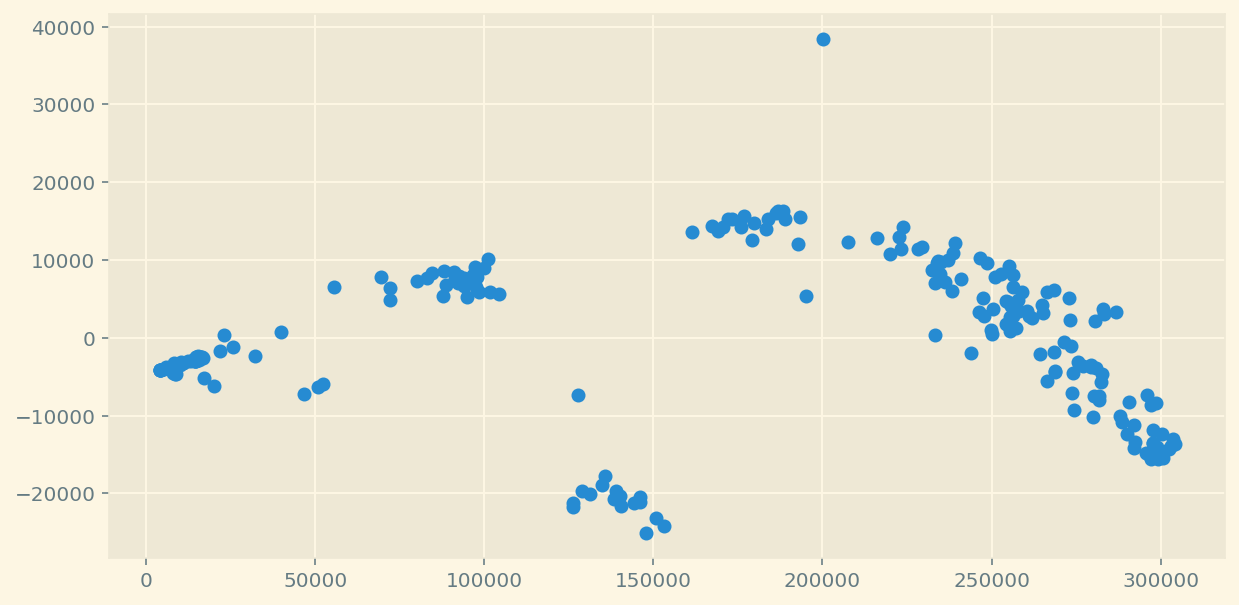

In [42]:
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.api as sms
from scipy.stats import bartlett
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = previ_financial[['Passageiros']]
Y = previ_financial[['Valor Passageiros']]
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 16,test_size=0.20)


model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_train)
residuals = y_train.values-y_pred
mean_residuals = np.mean(residuals) # média dos redíduos
test_norm = stats.shapiro(residuals) # teste de normalidade - shapiro will
test_ind = durbin_watson(residuals) # teste de indeperdência - durbin watson
test_homo = sms.het_goldfeldquandt(residuals, X_train) # teste homocestacidade - 



print(f"Média dos Resíduos {mean_residuals}")
print(f"Normalidade dos Resíduos: {test_norm[1]}")
print(f"Teste de Indepedência: {test_ind}")
print(f"Teste de Homocestacidade: {test_homo[1]}")

fig, axs = plt.subplots(sharey=True)
fig.set_size_inches(10,5)
plt.scatter(y_pred,residuals)
plt.show()
  
#https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression


In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

dec_tree = DecisionTreeRegressor(random_state=0)
dec_tree.fit(X_train,y_train)
dec_tree_y_pred = dec_tree.predict(X_train)
print("Accuracy: {}".format(dec_tree.score(X_train,y_train)))
print("R squared: {}".format(r2_score(y_true=y_train,y_pred=dec_tree_y_pred)))

Accuracy: 1.0
R squared: 1.0
